## 第10組：期末報告
### 主題：合庫金庫評論分析
組員：M134020018 吳信輝、M134020045 呂明翰、M134020034 黃沛萱
<hr>

### 動機分析與目的
探討合作金庫 App 在 Google Play 上的使用者評論，深入了解用戶在使用過程中遭遇的主要問題，例如「無法登入」、「更新失敗」與「轉帳問題」，並藉由這些評論掌握產品操作流程中的痛點與不足之處。此外，分析不同時期與版本下的評論分布情形，進一步評估產品更新與功能改進措施的成效，同時觀察用戶從新舊版本轉換時情緒與滿意度的變化。透過這些分析，期望為產品優化提供數據支援與建議。
<hr>

### 資料說明
本專案資料來源於 Google Play 爬蟲，蒐集合作金庫 App 於 2017 至 2024 年間台灣地區的使用者評論，總計 3006 筆。  
資料欄位包含：

- `reviewId`：評論唯一識別碼  
- `score`：評分（1~5分）  
- `content`：評論內容  
- `at`：評論日期  
- `appVersion`：App 版本  
- `userName`：用戶名稱  

本專案將針對上述資料進行主題分析與視覺化，探討不同時期、版本下的用戶回饋與主題分布。

## 1. 載入套件


In [ ]:
import time
from functools import reduce
from collections import Counter
from pprint import pprint

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
import networkx as nx


import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus
from wordcloud import WordCloud
from nltk import ngrams, FreqDist
import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False

FontPath = 'SourceHanSansTW-Regular.otf' # 設定字型

## 2. 資料前處理

### 資料前處理說明

1. 匯入原始資料，僅保留需要的欄位（reviewId、score、content、at、appVersion、userName）。
2. 移除評論內容中的網址，只保留純文字。
3. 將評論日期轉換為 datetime 格式，方便後續分析。
4. 將 appVersion 欄位簡化為主版本號（例如 3.22.1 → 3.22）。
5. 設定繁體中文斷詞詞庫，並載入停用詞表。
6. 使用 jieba 進行中文斷詞，並移除停用詞及單字，僅保留有意義的詞彙。
7. 將斷詞結果新增為 words 欄位，作為後續主題分析的基礎。

In [ ]:
df = pd.read_csv("merged_data.csv")  # 匯資料

df = df[['reviewId', 'score', 'content', 'at', 'appVersion','userName']]
df.head(3)

,reviewId,score,content,at,appVersion,userName
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15.1219,Google 使用者
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,3,希望可以新增圖形手勢或是指紋登入,2017-12-22 16:00:34,3.15.1219,Google 使用者
2,ed390033-a91c-4146-bde7-d4533145e9ba,1,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,2017-12-21 12:25:16,3.15.1219,Google 使用者


In [ ]:
df["content"] = df["content"].str.replace("(http|https)://.*", "", regex=True)
df["content"] = df["content"].str.replace(r"\d+(\.\d+)?", "", regex=True)
df['artDate'] = pd.to_datetime(df['at'])
df['appVersion'] = df['appVersion'].str.split('.').str[:2].str.join('.')

df = df.loc[:,['reviewId', 'score', 'content', 'artDate', 'appVersion','userName']]  # 文章內容 文章連結
df.head(3)

,reviewId,score,content,artDate,appVersion,userName
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15,Google 使用者
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,3,希望可以新增圖形手勢或是指紋登入,2017-12-22 16:00:34,3.15,Google 使用者
2,ed390033-a91c-4146-bde7-d4533145e9ba,1,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,2017-12-21 12:25:16,3.15,Google 使用者


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

stopwords_manual = ["app", "APP", "銀行", "使用", "一直", "手機"]
stopWords.extend(stopwords_manual)

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

df["words"] = df["content"].apply(getToken)
df.head()

Building prefix dict from c:\Users\User\Desktop\SMFinal\sb\dict\dict.txt.big ...
2025-06-10 16:21:09,889 : DEBUG : Building prefix dict from c:\Users\User\Desktop\SMFinal\sb\dict\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.u3f04f68d2a0412af4ae1b877454d8a35.cache
2025-06-10 16:21:09,889 : DEBUG : Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.u3f04f68d2a0412af4ae1b877454d8a35.cache
Loading model cost 0.586 seconds.
2025-06-10 16:21:10,476 : DEBUG : Loading model cost 0.586 seconds.
Prefix dict has been built successfully.
2025-06-10 16:21:10,476 : DEBUG : Prefix dict has been built successfully.


,reviewId,score,content,artDate,appVersion,userName,words
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]"
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,3,希望可以新增圖形手勢或是指紋登入,2017-12-22 16:00:34,3.15,Google 使用者,"[希望, 新增, 圖形, 手勢, 指紋, 登入]"
2,ed390033-a91c-4146-bde7-d4533145e9ba,1,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,2017-12-21 12:25:16,3.15,Google 使用者,"[五顆星, 員工, 載入, 無法, 進入, 有沒有, 搞錯, 大哥]"
3,7eb57a03-e2dc-4bba-a0bd-9a059d6c0254,5,平安，很好。,2017-12-20 16:00:13,3.15,Google 使用者,[平安]
4,90a8f503-05a0-4459-9b53-a9d57439cc7b,3,為什麼沒有台幣定存,2017-12-20 08:43:32,3.15,Google 使用者,"[台幣, 定存]"


## 3. 詞頻與文字雲

In [ ]:
from collections import Counter

FontPath = 'SourceHanSansTW-Regular.otf' # 設定字型
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 100)

# 以斷詞後的詞彙統計出現次數，製作文字雲

# 將所有 words 欄位展平成一個 list
all_words = [word for words in df['words'] for word in words]
freq_dict = Counter(all_words)

c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


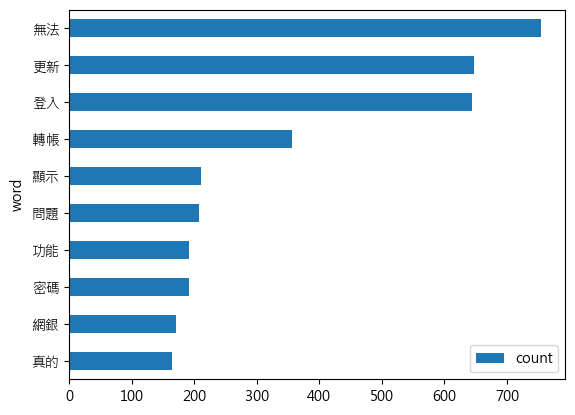

In [ ]:
# 將 freq_dict 轉為 DataFrame 並繪製橫條圖
freq_df_plot = pd.DataFrame(list(freq_dict.items()), columns=['word', 'count']).sort_values(by='count', ascending=False)
freq_df_plot.head(10).plot.barh(x='word', y='count')
plt.gca().invert_yaxis()
plt.show()

圖中可以看到使用者常提到的關鍵字與困擾，像是「更新後無法登入」、「顯示錯誤」、「資料無法同步」等等，這些都反映在使用者留言的高頻關鍵詞上。

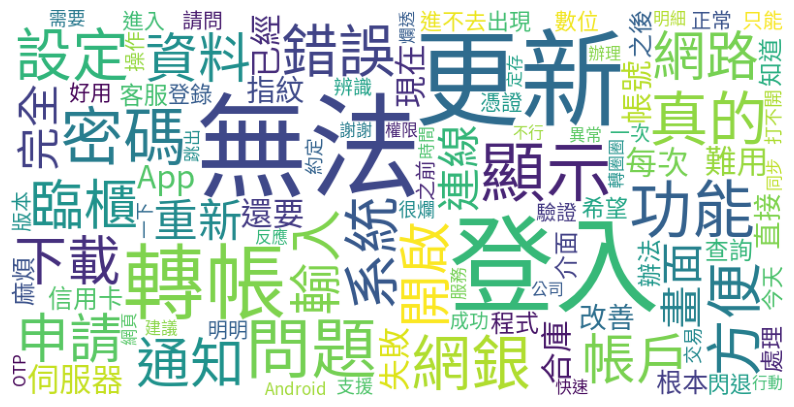

In [ ]:
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- 無法、登入、更新、密碼、問題：顯示使用者最常遇到的登入或帳號相關困擾。

- 網銀、申請、設定、功能、下載、通知：可能關聯到操作流程、介面功能、或使用說明方面的議題。

- 轉帳、臨櫃、系統、網路、顯示：指向使用者在交易、系統穩定性或可用性方面的經驗或反饋。


 字雲呈現出來的高頻詞，像是「無法」、「更新」、「登入」、「錯誤」、「下載」等，都是反映使用者抱怨的熱點詞，對後續做情感分析與主題分類會有幫助。

## 4. 情緒分析

In [ ]:
df['score'].value_counts()

score
1    1936
5     446
2     284
3     215
4     125
Name: count, dtype: int64

**統計結果如下：**

負評數量明顯高於正評（1936 筆為 1 星）

顯示使用者對 App 整體體驗偏負面。

In [ ]:
df['appVersion'].value_counts()

appVersion
3.17    873
3.16    448
3.18    300
3.19    255
3.21    239
3.20    178
3.22    178
3.13    115
3.14     76
3.15     71
3.11      4
3.12      3
Name: count, dtype: int64

**說明：**

利用使用者留言的「評分」作為情緒分類依據：

4–5：正向

3：中立

1–2：負向

In [ ]:
df_sentiment = df.copy()

def score_to_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score <= 2:
        return 'negative'
    else:
        return 'neutral'

df_sentiment['sentiment'] = df_sentiment['score'].apply(score_to_sentiment)
df_sentiment.head()

,reviewId,score,content,artDate,appVersion,userName,words,sentiment
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]",negative
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,3,希望可以新增圖形手勢或是指紋登入,2017-12-22 16:00:34,3.15,Google 使用者,"[希望, 新增, 圖形, 手勢, 指紋, 登入]",neutral
2,ed390033-a91c-4146-bde7-d4533145e9ba,1,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,2017-12-21 12:25:16,3.15,Google 使用者,"[五顆星, 員工, 載入, 無法, 進入, 有沒有, 搞錯, 大哥]",negative
3,7eb57a03-e2dc-4bba-a0bd-9a059d6c0254,5,平安，很好。,2017-12-20 16:00:13,3.15,Google 使用者,[平安],positive
4,90a8f503-05a0-4459-9b53-a9d57439cc7b,3,為什麼沒有台幣定存,2017-12-20 08:43:32,3.15,Google 使用者,"[台幣, 定存]",neutral


In [ ]:
word_df = df_sentiment.explode('words').rename(columns={'words': 'word'})
word_df.head(3)

,reviewId,score,content,artDate,appVersion,userName,word,sentiment
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15,Google 使用者,更新,negative
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15,Google 使用者,完全,negative
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15,Google 使用者,登入,negative


In [ ]:
version_sentiment_count = df_sentiment.groupby(['appVersion', 'sentiment']).size().unstack(fill_value=0).rename_axis(columns=None).reset_index()
version_sentiment_count.head(3)

,appVersion,negative,neutral,positive
0,3.11,4,0,0
1,3.12,3,0,0
2,3.13,84,12,19


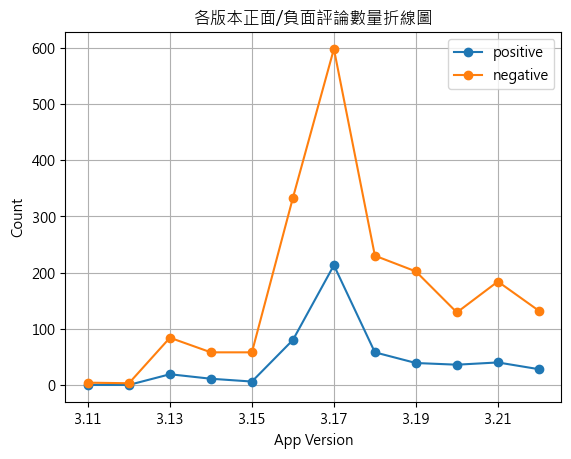

In [ ]:
version_sentiment_count_sorted = version_sentiment_count.sort_values('appVersion')
version_sentiment_count_sorted.set_index('appVersion')[['positive', 'negative']].plot(kind='line', marker='o')
plt.xlabel('App Version')
plt.ylabel('Count')
plt.title('各版本正面/負面評論數量折線圖')
plt.grid(True)
plt.show()

📌 說明：

將情緒分群後，對各版本進行統計。

繪製「每個 App 版本對應的正/負評數量折線圖」。

📷 圖片說明：

例如在 3.17 版本，負評數量最高，達 約 600 筆，是爭議最大的版本。

同一版本也有一定數量的正評，顯示使用者回饋意見分歧。

其他版本則多為低量負評，情緒波動較小。

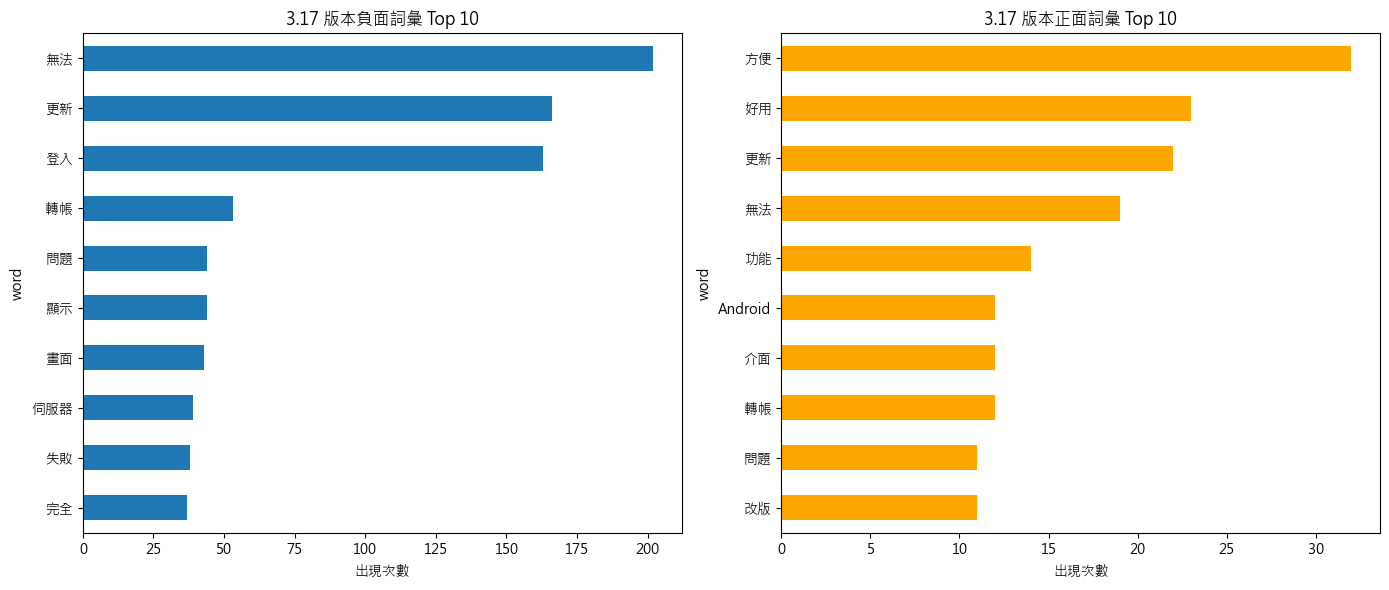

In [ ]:
import matplotlib.pyplot as plt

# 計算 3.17 版本下負面詞彙的出現次數
negative_word_counts_317 = word_df[
    (word_df['sentiment'] == 'negative') &
    (word_df['appVersion'] == '3.17')
]['word'].value_counts()

# 計算 3.17 版本下正面詞彙的出現次數
positive_word_counts_317 = word_df[
    (word_df['sentiment'] == 'positive') &
    (word_df['appVersion'] == '3.17')
]['word'].value_counts()

# 建立圖形和子圖（並排兩張）
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 負面詞彙圖
negative_word_counts_317.head(10).sort_values().plot.barh(ax=axes[0])
axes[0].set_title('3.17 版本負面詞彙 Top 10')
axes[0].set_xlabel('出現次數')

# 正面詞彙圖
positive_word_counts_317.head(10).sort_values().plot.barh(ax=axes[1], color='orange')
axes[1].set_title('3.17 版本正面詞彙 Top 10')
axes[1].set_xlabel('出現次數')

# 自動調整圖表排版
plt.tight_layout()
plt.show()


- 左圖（負面詞彙 Top 10）： 顯示在使用者負評中最常出現的關鍵字。出現次數最多的是：
    - 無法（約 200 次）
    - 更新（約 150 次）
    - 登入、轉帳、問題等字詞也頻繁出現，與功能障礙、操作困難有關。
- 右圖（正面詞彙 Top 10）： 顯示在正評中出現的高頻詞彙，例如：
    - 方便（約 30 次）
    - 好用、功能、更新等字詞也有出現，代表部分使用者肯定某些設計或效能。

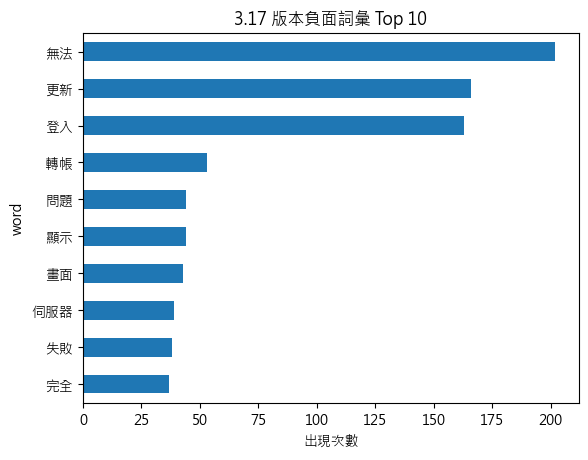

In [ ]:
# 計算 3.17 版本下負面詞彙的出現次數
negative_word_counts_317 = word_df[(word_df['sentiment'] == 'negative') & (word_df['appVersion'] == '3.17')]['word'].value_counts()

# 繪製橫條圖
negative_word_counts_317.head(10).sort_values().plot.barh()
plt.xlabel('出現次數')
plt.title('3.17 版本負面詞彙 Top 10')
plt.show()

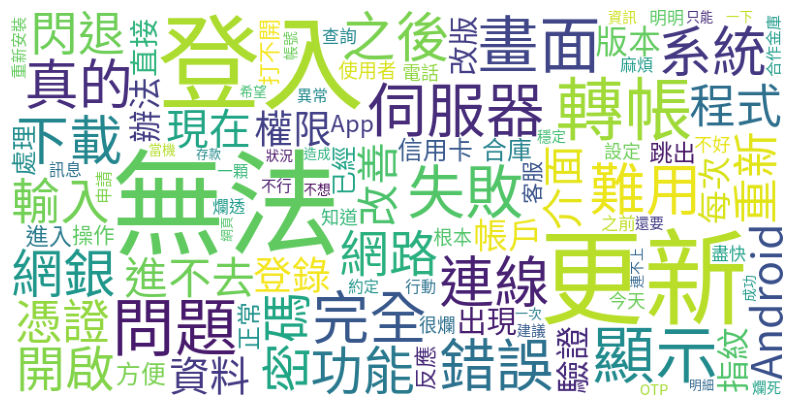

In [ ]:
wordcloud.generate_from_frequencies(negative_word_counts_317)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

字雲補充視覺化（負評字雲）

📷 說明字雲：

將 3.17 版本的所有負評斷詞結果輸入 WordCloud。

清楚看到「登入」「無法」「系統」「錯誤」「轉帳」等字詞放大，進一步佐證問題集中在帳號功能與系統穩定性。

## 5. CKIP標註

In [ ]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import re
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime

In [ ]:
data_utils.download_data_gdown("./")

In [ ]:
ws = WS("./data")
pos = POS("./data")

c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


In [ ]:
df = pd.read_csv("merged_data.csv")  # 匯資料

df = df[['reviewId', 'score', 'content', 'at', 'appVersion','userName']]
df.head(3)

,reviewId,score,content,at,appVersion,userName
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15.1219,Google 使用者
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,3,希望可以新增圖形手勢或是指紋登入,2017-12-22 16:00:34,3.15.1219,Google 使用者
2,ed390033-a91c-4146-bde7-d4533145e9ba,1,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,2017-12-21 12:25:16,3.15.1219,Google 使用者


In [ ]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")


    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)

    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)

            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space

            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)

        except:
            return "error"

        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)

    return result

In [ ]:
# 自定義辭典
with open('dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(3, {'金融卡': 500.0}), (4, {'合作金庫': 500.0, '行動銀行': 500.0, '網銀服務': 500.0, '數位帳戶': 500.0, '活儲利率': 500.0, '定存利率': 500.0, '轉帳功能': 500.0, '跨行轉帳': 500.0, '掃碼支付': 500.0, '網路銀行': 500.0, '金融服務': 500.0, '身分驗證': 500.0, '語音客服': 500.0, '用戶介面': 500.0, '手機認證': 500.0, '帳號查詢': 500.0, '交易明細': 500.0, '預約開戶': 500.0, '推播通知': 500.0, '生活繳費': 500.0, '利率查詢': 500.0, '匯率查詢': 500.0, '客服人員': 500.0, '簡訊驗證': 500.0, '臉部辨識': 500.0, '系統維護': 500.0, '更新失敗': 500.0, '密碼重設': 500.0, '指紋辨識': 500.0, '餘額查詢': 500.0, '帳戶資訊': 500.0, '手機銀行': 500.0, '分行據點': 500.0, '金融科技': 500.0, '客戶權益': 500.0, '手機號碼': 500.0, '用戶體驗': 500.0, '數位服務': 500.0, '綁定裝置': 500.0, '交易失敗': 500.0, '轉帳紀錄': 500.0, '常用帳號': 500.0, '密碼錯誤': 500.0, '帳戶餘額': 500.0, '台新銀行': 500.0, '永豐銀行': 500.0, '中國信託': 500.0, '國泰世華': 500.0, '玉山銀行': 500.0, '華南銀行': 500.0, '第一銀行': 500.0, '兆豐銀行': 500.0, '台北富邦': 500.0, '高雄銀行': 500.0, '新光銀行': 500.0, '土地銀行': 500.0, '彰化銀行': 500.0, '陽信銀行': 500.0, '聯邦銀行': 500.0, '元大銀行': 500.0, '安泰銀行': 500.0, '渣打銀行': 500.0, '星展銀行': 500.0, '花旗銀行': 500.0, '日盛銀行': 500.0

In [ ]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos])
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    sentence_list = []

    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level
    # print(f"\ndocument {index}")

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['content'])
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['reviewId'], sentence])
            temp_tokens = get_pos(row['reviewId'], word_sentence_list[i], pos_sentence_list[i])

            pos_list.append(temp_tokens)

    pos_flat = [item for sublist in pos_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat,
                    columns=['reviewId','word','pos'])

    sentence_table = pd.DataFrame(data=sentence_list,
                    columns=['reviewId','sentence'])

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, sentence_table

In [ ]:
pos_table, sentence_table = get_nlp_result(df)

time costing: 42.79389929771423


In [ ]:
pos_table.head() # word pos 列表

,reviewId,word,pos
0,179e2c16-8898-4086-96ff-b897f0284ac4,更新,VC
1,179e2c16-8898-4086-96ff-b897f0284ac4,後,Ng
2,179e2c16-8898-4086-96ff-b897f0284ac4,完全,D
3,179e2c16-8898-4086-96ff-b897f0284ac4,登入,VCL
4,179e2c16-8898-4086-96ff-b897f0284ac4,不,D


In [ ]:
sentence_table.head()

,reviewId,sentence
0,179e2c16-8898-4086-96ff-b897f0284ac4,更新後完全登入不進去，請立即改善
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,希望可以新增圖形手勢或是指紋登入
2,ed390033-a91c-4146-bde7-d4533145e9ba,按五顆星的自己員工逆
3,ed390033-a91c-4146-bde7-d4533145e9ba,載入都無法進入的有沒有搞錯啊錢不是這樣花的阿大哥
4,7eb57a03-e2dc-4bba-a0bd-9a059d6c0254,平安，很好


### 5.1 POS 種類分析
查看辨識出哪幾種POS<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [ ]:
pos_table['pos'].unique()

array(['VC', 'Ng', 'D', 'VCL', 'VA', 'COMMACATEGORY', 'VF', 'VK', 'VJ',
       'Na', 'Caa', 'P', 'Neu', 'Nf', 'DE', 'Nh', 'T', 'SHI', 'VH', 'Nb',
       'Dfa', 'VE', 'Nep', 'VB', 'VHC', 'VG', 'Nd', 'Di', 'A', 'V_2',
       'Cbb', 'VL', 'Nv', 'Nc', 'FW', 'Nes', 'VD', 'Neqa', 'Cab', 'Da',
       'Dfb', 'Ncd', 'Neqb', 'Cba', 'VAC', 'PERIODCATEGORY', 'Dk', 'I',
       'VI', 'PAUSECATEGORY', 'PARENTHESISCATEGORY', 'DM'], dtype=object)

In [ ]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
5,D,9795
15,Na,6642
36,VC,5751
42,VH,3838
33,VA,1542
6,DE,1211
29,P,1209
9,Dfa,1157
39,VE,1143
37,VCL,1118


#### POS 常見詞性列表
+ Na: 普通名詞
+ D: 副詞
+ VC: 動作及物動詞
+ Nb: 專有名詞
+ FW: 外文
+ VH: 狀態不及物動詞
+ Nh: 代名詞
+ DE: 的之得地
+ P: 介詞
+ VA: 動作不及物動詞
+ T: 語助詞
+ SHI: 是

C:\Users\User\AppData\Local\Temp\ipykernel_15156\2478466374.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


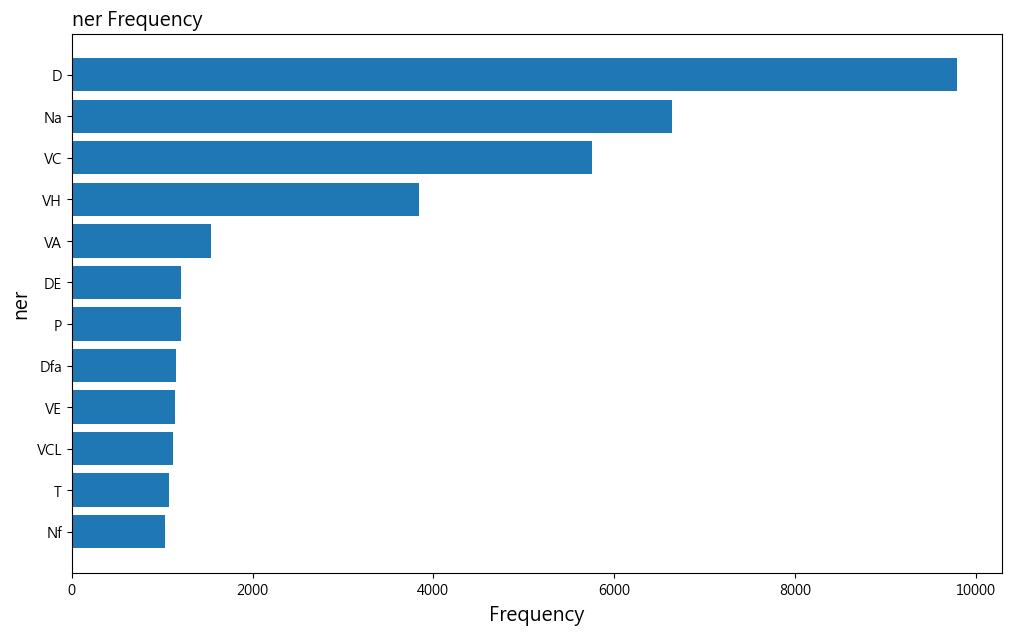

In [ ]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

詞性統計幫助我們更清楚知道哪些詞彙類型最常出現，也有助於後續針對名詞（Na）或動詞（VC）進行主題建模與語意分析。


### 5.2 涉及到的名詞(Noun)
+ 常見專有名詞(Nb)可以協助我們了解使用者對App內各項功能與特色的關注焦點。
+ 專有名詞則多包含系統相關名詞，對於探索用戶體驗反饋很有幫助。

In [ ]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
16,台新,13
20,安卓,11
2,中信,9
17,國泰,6
4,中國信託,5
1,三星,5
54,資安,4
30,拉基,3
50,華為,3
25,富邦,3


C:\Users\User\AppData\Local\Temp\ipykernel_15156\4129530073.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


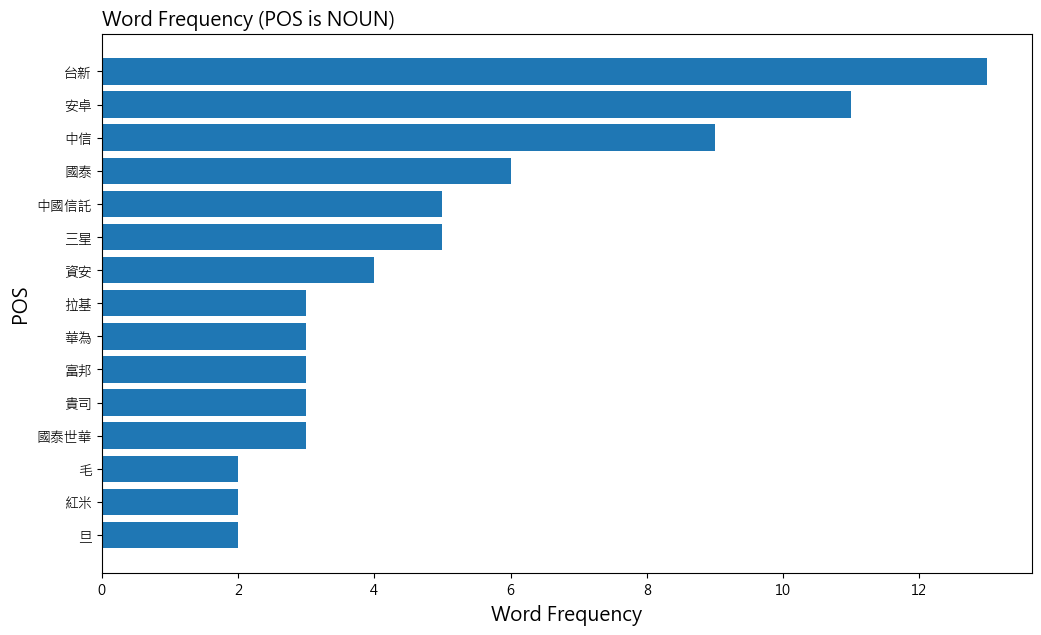

In [ ]:
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

高頻名詞集中於金融機構與裝置平台
- 銀行名詞如：「台新」、「中信」、「國泰」、「中國信託」、「富邦」、「國泰世華」等頻繁出現，顯示使用者常提及其他競品銀行進行比較，可能涉及功能、體驗或服務的優劣。
- 裝置/平台名詞如：「安卓」、「三星」、「華為」、「紅米」、「資安」也佔有明顯比例，表示使用者在評論中會討論與裝置相容性、操作問題或資安問題。

### 5.3 動作及物動詞(VC)
以下分析主要聚焦在及物動詞(VC)，探討用戶在使用App時的主要動作與行為模式。

In [ ]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
273,更新,580
10,使用,401
403,設定,130
2,下載,125
521,開啟,122
445,輸入,117
478,通知,104
247,改善,93
322,登錄,72
386,處理,69


C:\Users\User\AppData\Local\Temp\ipykernel_15156\29217454.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


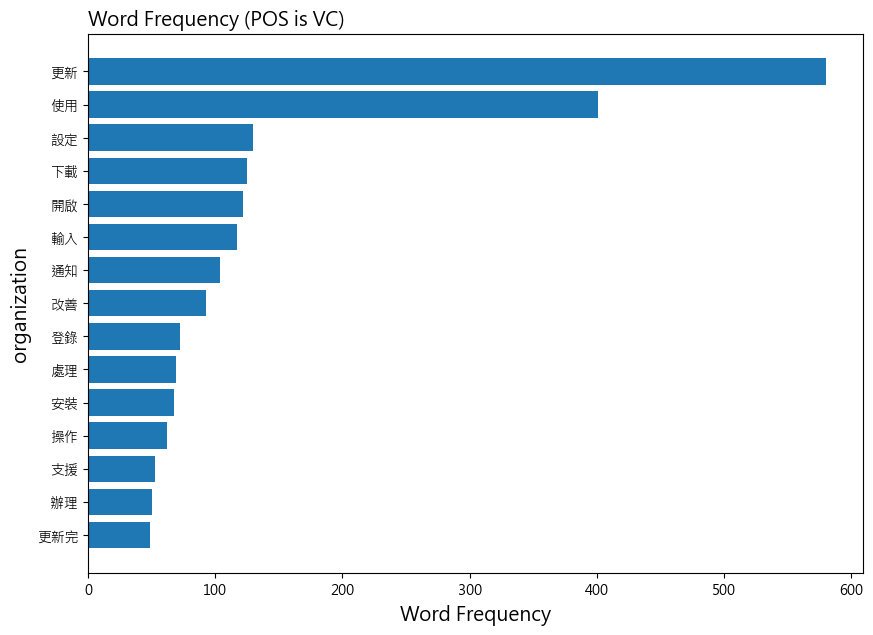

In [ ]:
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is VC)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

- 更新出現次數遠高於其他動詞，顯示：
    - 用戶大量提到「無法更新」、「更新失敗」、「更新後出問題」等情境。
    - 版本更新的穩定性與可用性是最常被批評的問題來源。
- 「使用」排名第二，反映操作體驗被大量討論
    - 使用說明用戶對實際操作 APP 的流暢性、直覺性、功能完整性有高度關注。
    - 「使用不便」、「使用困難」可能是主要情緒來源。
- 「改善」、「支援」、「處理」、「辦理」出現，透露出問題反映與期望

### 5.4 狀態不及物動詞(VH)

In [ ]:
l_verb = ["VH"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
221,方便,160
134,好用,128
333,直接,100
122,失敗,97
432,這樣,86
461,錯誤,82
63,出現,77
249,正常,66
206,成功,56
190,快速,48


C:\Users\User\AppData\Local\Temp\ipykernel_15156\840033311.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


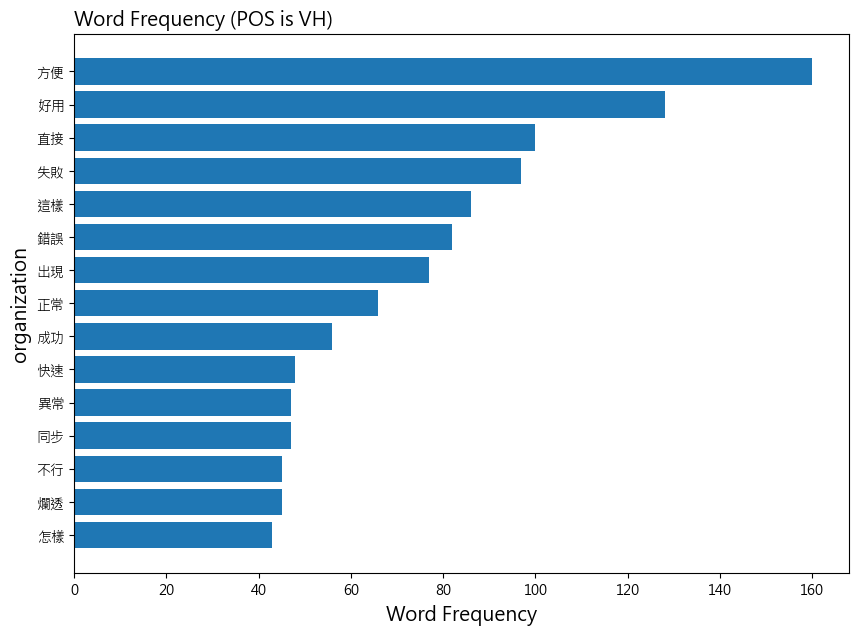

In [ ]:
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is VH)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

- 「方便」、「好用」為最高頻狀態詞，顯示肯定情緒存在
- 失敗、錯誤、爛透、異常、不行 等詞合計頻率也非常高，有相當比例的使用者經驗過 APP 錯誤、操作失敗等問題。

### 5.5 動作不及物動詞(VA)

In [ ]:
l_verb = ["VA"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
198,轉帳,306
213,進去,118
153,臨櫃,115
221,閃退,64
225,開戶,38
107,改版,34
67,幹嘛,26
146,繳款,21
167,認證,21
30,出來,17


C:\Users\User\AppData\Local\Temp\ipykernel_15156\403714612.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


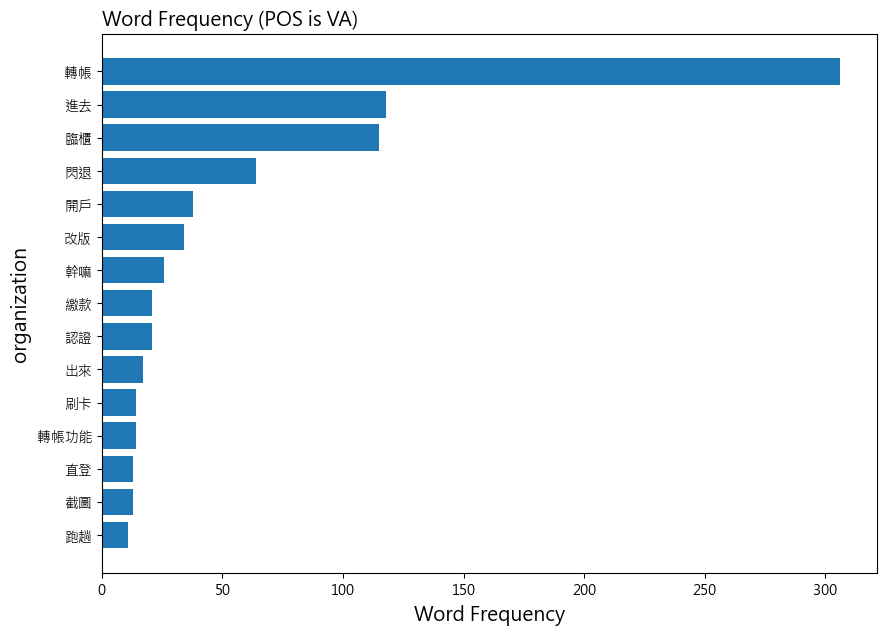

In [ ]:
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is VA)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

- 「轉帳」壓倒性最高，顯示此功能是使用者關注核心
- 「進去」、「開戶」、「登入」、「臨櫃」等詞反映登入或辦理流程，例如「進去」常出現在「進去 APP 卡住」、「進不去」等語境。
- 「閃退」出現頻率偏高，顯示APP穩定性存在問題

## 6. TF-IDF
根據tfidf值來挑出重要詞彙，取每一個字詞在所有文件裡的TF-IDF平均值

In [ ]:
MetaData = df.copy()
MetaData['content'] = MetaData['content'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData['word'] = MetaData.content.apply(getToken).map(' '.join)
MetaData = MetaData[['content', 'word']]
MetaData.head(3)

,content,word
0,更新後完全登入不進去請立即改善,更新 完全 登入 立即 改善
1,希望可以新增圖形手勢或是指紋登入,希望 新增 圖形 手勢 指紋 登入
2,按五顆星的自己員工逆載入都無法進入的有沒有搞錯啊錢不是這樣花的阿大哥,五顆星 員工 載入 無法 進入 有沒有 搞錯 大哥


In [ ]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(MetaData["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一下,一下下,一下子,一下站,一不小心,一串,一事,一些,一人,一位,...,點觸,點選,點還,點都,點錯,點開,點點,鼓勵,齊全,龐大
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
transformer = TfidfTransformer()
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一下,一下下,一下子,一下站,一不小心,一串,一事,一些,一人,一位,...,點觸,點選,點還,點都,點錯,點開,點點,鼓勵,齊全,龐大
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tfidf = TFIDF_df.mean().to_frame().reset_index()
tfidf.columns = ["word", "avg"]

tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
2464,無法,0.060441
2085,更新,0.048457
2643,登入,0.047583
1992,方便,0.022211
3488,轉帳,0.020998
4052,顯示,0.014263
3978,難用,0.014098
3644,連線,0.013895
1184,好用,0.013825
962,問題,0.013275


- 無法：tfidf 最高的詞，顯示其在評論中不僅出現頻率較高，而且具區分性，可能代表使用者反映的「無法」連線、登入或更新等操作失敗的問題。
- 更新：代表軟體版本更新後相關問題，顯示在評論中討論更新狀況具有較高重要性及區分度。

## 7. N-gram

### 7.1 Bigram

In [ ]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]

    return seg_list

In [ ]:
bigram = df.copy()
bigram['content'] = bigram['content'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
bigram['word'] = bigram['content'].apply(lambda row: ngram_getToken(row, 2))
bigram = bigram.explode('word')
bigram.head(3)

,reviewId,score,content,artDate,appVersion,userName,words,word
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去請立即改善,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]",更新 完全
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去請立即改善,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]",完全 登入
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去請立即改善,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]",登入 立即


In [ ]:
# 計算每個組合出現的次數
bigram_count = bigram['word'].value_counts().reset_index()

bigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,無法 登入,234
1,更新 無法,71
2,數位 帳戶,49
3,更新 之後,41
4,無法 進入,37
5,無法 連線,37
6,完全 無法,35
7,驗證 失敗,34
8,無法 更新,33
9,重新 下載,31


單一詞語有時語意不足，透過 Bigram 方式，我們可以發掘出常見且具語意的詞對，例如「無法 登入」、「顯示 異常」、「更新 後」等，這些詞組在後續主題模型中能提供更精準的語意特徵，有助於提升 LDA 分群準確度與可解釋性。

### 7.2 Trigram

In [ ]:
trigram = df.copy()
trigram['content'] = trigram['content'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
trigram['word'] = trigram['content'].apply(lambda row: ngram_getToken(row, 3))
trigram = trigram.explode('word')

trigram.head(3)

,reviewId,score,content,artDate,appVersion,userName,words,word
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去請立即改善,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]",更新 完全 登入
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去請立即改善,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]",完全 登入 立即
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去請立即改善,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]",登入 立即 改善


In [ ]:
# 計算每個組合出現的次數
trigram_count = trigram['word'].value_counts().reset_index()

trigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,更新 無法 登入,30
1,憑證 驗證 失敗,21
2,伺服器 憑證 驗證,18
3,完全 無法 登入,15
4,伺服器 無法 連線,13
5,伺服器 驗證 失敗,10
6,無法 登入 顯示,10
7,發生 預期 錯誤,9
8,看看 看看 看看,9
9,更新 完全 無法,9


在 Bigram 分析中，我們只考慮了兩個連續詞語的關係，而 Trigram 則是每 3 個詞 組成一個詞組，這能更準確捕捉使用者回饋中的完整語意片段。

### 7.3 Bigram視覺化

In [ ]:
bigramfdist = bigram.copy()
bigramfdist['content'] = bigram['content'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
bigramfdist["word"] = bigramfdist['content'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')
bigramfdist = bigramfdist[bigramfdist['word'].notna()]

bigramfdist.head(3)

,reviewId,score,content,artDate,appVersion,userName,words,word
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去請立即改善,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]",更新 完全
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去請立即改善,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]",完全 登入
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去請立即改善,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]",登入 立即


In [ ]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('數位', '帳戶'), 2637),
 (('無法', '登入'), 2013),
 (('約定', '轉帳'), 1050),
 (('快速', '登入'), 602),
 (('基金', '報酬率'), 539)]

In [ ]:
d = {k:v for k,v in bigramfdist.most_common(50)}

In [ ]:
# Create network plot
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率

# 取得調整edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

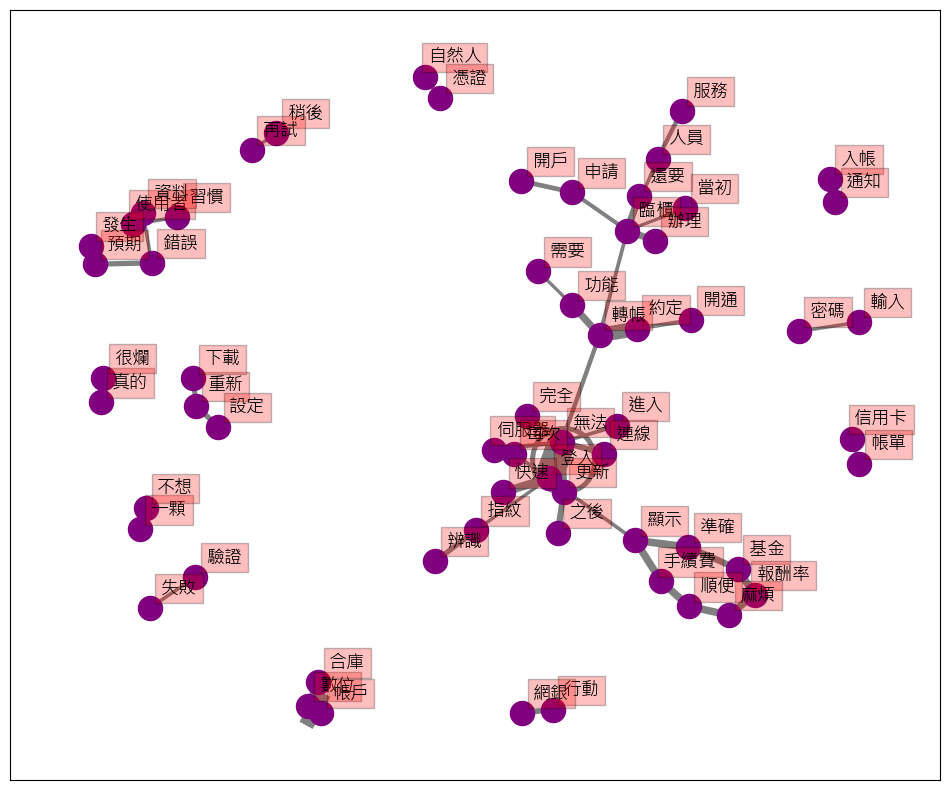

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

分析使用者對金融產品或服務的抱怨點（如「無法」、「登入」、「錯誤」、「驗證失敗」）
- 中心區域詞語包括： 無法、登入、更新、連線、伺服器、指紋、辨識，表示使用者遇到障礙或操作失敗。
- 使用者體驗：下載、設置、更新問題經常共現

## 8. Pairwise correlation
計算詞彙間的相關性

In [ ]:
data_cor = df.copy()
# 保留中文和英文，只去掉非中英文字符
data_cor['content'] = df['content'].apply(lambda x: re.sub('[^\u4e00-\u9fffA-Za-z]+', '', x))
# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.content.apply(getToken).map(' '.join)
data_cor = data_cor[data_cor['word'].notna() & (data_cor['word'] != '')]
data_cor

,reviewId,score,content,artDate,appVersion,userName,words,word
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去請立即改善,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]",更新 完全 登入 立即 改善
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,3,希望可以新增圖形手勢或是指紋登入,2017-12-22 16:00:34,3.15,Google 使用者,"[希望, 新增, 圖形, 手勢, 指紋, 登入]",希望 新增 圖形 手勢 指紋 登入
2,ed390033-a91c-4146-bde7-d4533145e9ba,1,按五顆星的自己員工逆載入都無法進入的app有沒有搞錯啊錢不是這樣花的阿大哥,2017-12-21 12:25:16,3.15,Google 使用者,"[五顆星, 員工, 載入, 無法, 進入, 有沒有, 搞錯, 大哥]",五顆星 員工 載入 無法 進入 有沒有 搞錯 大哥
3,7eb57a03-e2dc-4bba-a0bd-9a059d6c0254,5,平安很好,2017-12-20 16:00:13,3.15,Google 使用者,[平安],平安
4,90a8f503-05a0-4459-9b53-a9d57439cc7b,3,為什麼沒有台幣定存,2017-12-20 08:43:32,3.15,Google 使用者,"[台幣, 定存]",台幣 定存
...,...,...,...,...,...,...,...,...
3001,256c78ca-38a0-4954-a18b-2824d8c946de,2,原可轉帳更新app後OTP要跳出前都會出現訊息太久未操做多次試用都一樣,2024-01-03 19:30:13,3.21,Chris Lee,"[原可, 轉帳, 更新, OTP, 跳出, 出現, 訊息, 太久, 未操, 試用]",原可 轉帳 更新 OTP 跳出 出現 訊息 太久 未操 試用
3002,ef7f2908-14de-4ef1-9e81-c41dc7c99f4e,3,幾乎每次登入都要來一次同步資料真的非常浪費時間,2024-01-03 14:31:06,3.21,Peggy Lee,"[每次, 登入, 要來, 一次, 同步, 資料, 真的, 浪費時間]",每次 登入 要來 一次 同步 資料 真的 浪費時間
3003,b29d2236-757a-4945-8881-67066dfa3bff,1,一天到晚在更新所有銀行的app就屬你們最爛,2024-01-03 08:13:00,3.21,5 A (A5和牛),"[一天到晚, 更新, 所有, 就屬, 最爛]",一天到晚 更新 所有 就屬 最爛
3004,79733990-ecc2-44ff-8c08-01cde53e6fae,3,有夠難用到底有沒有在認真經營學學別家銀行啦,2024-01-02 18:45:40,3.21,CY Y,"[有夠, 難用, 有沒有, 認真, 經營, 學學, 別家]",有夠 難用 有沒有 認真 經營 學學 別家


In [ ]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,android,app,atm,bug,loading,otp,pay,ssl,一下,一個月,...,電話,需要,頁面,預期,顯示,餘額,首頁,驗證,體驗,麻煩
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,android,app,atm,bug,loading,otp,pay,ssl,一下,...,電話,需要,頁面,預期,顯示,餘額,首頁,驗證,體驗,麻煩
0,android,1.000000,0.035346,-0.009905,0.022290,-0.009037,0.013834,-0.011484,-0.010118,0.053634,...,0.200904,-0.016480,-0.011273,-0.009394,0.048927,-0.009705,-0.008163,-0.001458,0.014833,0.006850
1,app,0.035346,1.000000,0.001763,0.007840,0.077059,0.017454,-0.015711,0.043918,0.000530,...,0.030089,0.023605,-0.002351,0.025878,0.011429,-0.002365,-0.011168,0.045327,0.018959,0.000391
2,atm,-0.009905,0.001763,1.000000,-0.006122,-0.005748,0.029185,0.026350,0.023217,-0.010482,...,-0.007747,0.060594,-0.007171,-0.005975,-0.018616,0.038645,-0.005192,-0.010219,0.027918,0.021234
3,bug,0.022290,0.007840,-0.006122,1.000000,0.057387,0.017353,-0.007097,0.075098,0.022315,...,-0.007527,0.022315,-0.006967,-0.005806,-0.003591,-0.005998,-0.005045,0.017155,-0.006796,0.011522
4,loading,-0.009037,0.077059,-0.005748,0.057387,1.000000,-0.008505,-0.006665,-0.005872,0.025023,...,-0.007068,-0.009564,0.111015,-0.005452,-0.001556,-0.005632,-0.004737,-0.009324,-0.006382,-0.009712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,餘額,-0.009705,-0.002365,0.038645,-0.005998,-0.005632,-0.009134,0.016825,-0.006306,0.023496,...,0.129235,-0.010271,-0.007026,-0.005855,0.034480,1.000000,-0.005088,-0.010013,-0.006854,0.000928
296,首頁,-0.008163,-0.011168,-0.005192,-0.005045,-0.004737,-0.007683,-0.006020,-0.005304,-0.008639,...,-0.006385,-0.008639,-0.005909,-0.004924,-0.015342,-0.005088,1.000000,-0.008422,-0.005765,-0.008773
297,驗證,-0.001458,0.045327,-0.010219,0.017155,-0.009324,0.069502,-0.011848,0.082651,-0.017002,...,-0.012566,0.012749,-0.011631,-0.009692,0.062709,-0.010013,-0.008422,1.000000,0.010575,-0.007258
298,體驗,0.014833,0.018959,0.027918,-0.006796,-0.006382,0.011026,-0.008109,0.025775,0.040969,...,-0.008601,0.040969,-0.007961,-0.006634,-0.020668,-0.006854,-0.005765,0.010575,1.000000,-0.011818


In [ ]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
42103,帳戶,數位,0.804826
31040,數位,帳戶,0.804826
20106,pay,台灣,0.796720
1867,台灣,pay,0.796720
23826,手續費,基金,0.741910
37879,基金,手續費,0.741910
14364,通知,入帳,0.579745
79247,入帳,通知,0.579745
88090,發生,預期,0.556798
57293,預期,發生,0.556798


### 8.1 和 「無法」相關性最高的 10 個詞彙

In [ ]:
no_sum = word_cor_df[(word_cor_df["word1"] == "無法")].sort_values(by = ['cor'], ascending = False).head(10)

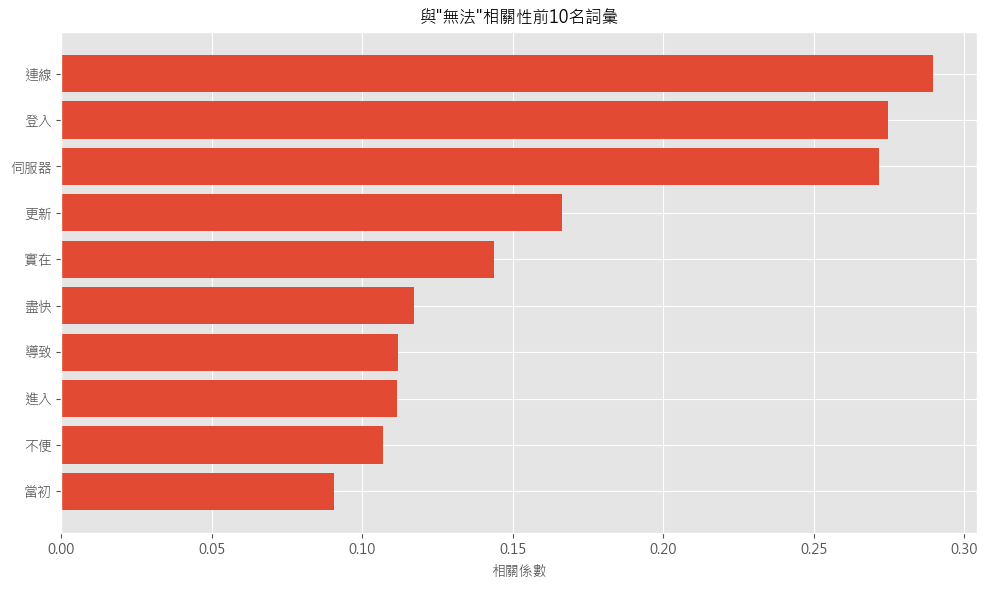

In [ ]:
plt.figure(figsize=(10,6))  # Adjust figure size
plt.style.use("ggplot")     # Use ggplot style

plt.title('與"無法"相關性前10名詞彙', fontsize=12)
plt.xlabel('相關係數', fontsize=10)
plt.barh(no_sum['word2'], no_sum['cor'])
plt.gca().invert_yaxis()

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

從圖中我們可以看出：
- 使用者常說「無法連線」、「無法登入」、「無法連接伺服器」、「無法更新」等。
- 這些詞是與「無法」最常共同出現的詞組，反映了使用者實際遇到的問題。


### 8.2 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.2的組合

In [ ]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [ ]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.2]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,重新,下載,0.210946
1,失敗,伺服器,0.236103
2,無法,伺服器,0.271494
3,連線,伺服器,0.531267
4,查詢,信用卡,0.208048
...,...,...,...
57,設定,重新,0.233108
58,顯示,錯誤,0.220517
59,錯誤,顯示,0.220517
60,麻煩,顯示,0.268548


In [ ]:
# Create network plot
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])

# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

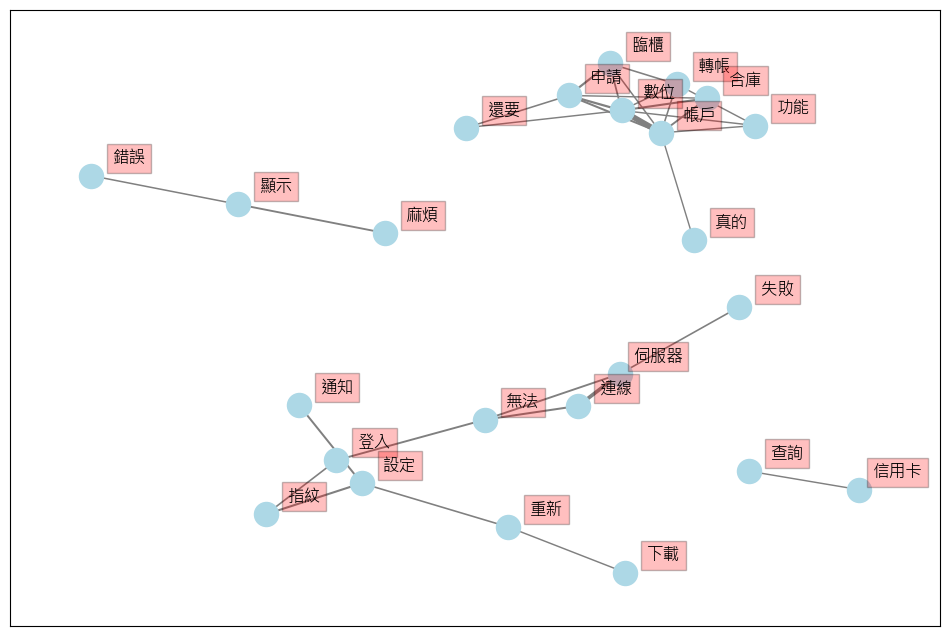

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)

plt.show()

我們基於前面計算出的詞語相關性，進一步加上詞頻篩選條件，建立了更具代表性的語意網路。透過 NetworkX 的視覺化，可以看出常見的問題詞串，例如「登入畫面無法顯示」、「權限設定錯誤」等，是產品優化的重要參考依據。



## 9. Lexicon-based / 人工給定主題的主題模型

#### 用各個頻分常見的詞來作為主題的代表詞

In [ ]:
## 定義主題 好棒棒的評論
score5 = df.loc[df['score'] == 5,:]['words'].explode().value_counts().head(100)
score5.index

Index(['方便', '好用', '更新', '功能', '轉帳', '不錯', '介面', '無法', '實用', '問題', '操作', '謝謝',
       '看看', '合庫', '指紋', '加油', '顯示', '希望', '服務', '真的', '改版', '登入', '快速', '網銀',
       '正常', 'good', '親切', 'Good', '設定', '直接', '便利', '辨識', '建議', 'App', '安全',
       '現在', '進步', '使用者', '很棒', '還好', '查詢', '新增', '簡單', '行動', '網路', '台灣', '自動',
       '明細', '選項', '畫面', '系統', '選擇', 'pay', '已經', '知道', '麻煩', '繼續', '辦法', '錯誤',
       '清楚', 'ok', '解決', '資料', '客服', '比較', '覺得', '頁面', '處理', '反應', '投資', '需要',
       '帳號', '重新', '之後', '改善', '感謝', '今天', '感覺', '金融', '密碼', 'Android', '開啟',
       '合作金庫', '簡單明瞭', '順手', '進入', '登錄', '通知', '截圖', '餘額', '成功', '業務', 'VISA',
       '友善', '感受', '交易', '變得', '可用', 'android', '設計'],
      dtype='object', name='words')

In [ ]:
score4 = df.loc[df['score'] == 4,:]['words'].explode().value_counts().head(200)
pprint(" ".join(score4.index))

('無法 登入 更新 設定 功能 Android 方便 通知 請問 希望 問題 定存 顯示 建議 交易 正常 不錯 目前 轉帳 App 支援 資料 好用 '
 '指紋 之前 已經 開啟 每次 伺服器 增加 修改 權限 今天 pay 帳戶 優惠 錯誤 新增 憑證 辨識 直接 閃退 解決 不到 新版 截圖 台幣 一點 '
 '螢幕 線上 介面 需要 出現 客服 一下 謝謝 進步 回覆 之後 合庫 失敗 改善 自動 解鎖 Pixel 操作 重新 台灣 常用 遮蔽 終於 黃金 '
 '入款 服務 改版 連結 生物 用心 部份 綜存轉 面部 加油 郵局 原本 選項 知道 瓦斯 裡面 代繳 一顆 零存整付 用戶 帳號 系統 XXXX 額度 '
 '分行 買賣 習慣 速度 收款 每月 驗證 這裡 訊號 升級 真是 煩請 android 感覺 存戶 輸入 只能 貴行 評價 登錄 辦法 密碼 畫面 申請 '
 '有點 打開 完成 是否 之內 反應 取消 活存 至少 合作金庫 下載 網路 美金 修正 不用 連線 感謝 icon 出入 桌面 代號 跨轉 次數 兆豐 '
 '帳的 過了 提醒 跨提 一段時間 第一 跟上 盪掉 分帳 名目 能夠 初次 美中不足 每日 數位 剩餘次數 資產 容易 回報 改為 PKQ Note '
 '應該 投資 理財 基金 紅米 環境 一目瞭然 加總 將登 入時 圖形 到位 若要 出生年月 隱藏 填寫 綁定 線條 加強 安全性 入帳 總覽 OTP '
 '明白 加入 免費 想要 連絡 欣桃 還要 電腦 滿意 工具 出台')


In [ ]:
score3 = df.loc[df['score'] == 3,:]['words'].explode().value_counts().head(200)
pprint(" ".join(score3.index))

('登入 更新 無法 顯示 密碼 功能 轉帳 通知 問題 希望 App 請問 定存 下載 錯誤 網銀 系統 方便 快速 今天 資料 已經 進入 之前 畫面 '
 '麻煩 改善 設定 重新 謝謝 是否 權限 輸入 開啟 每次 伺服器 指紋 信用卡 截圖 失敗 登出 正常 合庫 驗證 交易 查詢 解決 增加 跳出 台幣 '
 '網路 開放 真的 只能 辨識 支援 出現 一下 版本 程式 現在 入帳 行動 線上 連線 軟體 付款 盡快 帳號 存款 狀況 一次 異常 之後 需要 '
 '轉圈圈 服務 處理 即時 人員 打不開 應該 明細 帳號密碼 圖形 目前 看到 反應 安裝 介面 登錄 明明 辦理 操作 Android 辦法 直說 '
 '覺得 最近 內容 .... 很慢 餘額 取消 安卓 貴行 簡訊 知道 轉出 金額 刷卡 直接 讀取 登入後 訊息 選項 同步 完全 生物 解鎖 還要 '
 '帳戶 進不去 進步 代號 裡面 行員 新莊 修復 關閉 電話 允許 最後 偵測 修正 繳款 客服 分行 成功 返回 扣款 電腦 合作金庫 能否 更改 '
 '頁面 外匯 確定 情況 建議 憑證 買賣 推播 不行 備註 正確 速度 Pixel 用戶 匯款 幾天 首頁 外幣 工程師 應用程式 空間 官網 選擇 '
 '時間 過了 管理 提醒 黃金 難用 SSL 重新安裝 實在 異動 圖案 回饋 欄位 使用者 開機 可惜 不好 android 網頁 根本無法 變更 '
 'OTP 掃描 无法 莫名其妙 本金 英文 更好 陽春 方式 載入 我要')


In [ ]:
score2 = df.loc[df['score'] == 2,:]['words'].explode().value_counts().head(200)
pprint(" ".join(score2.index))

('登入 無法 更新 轉帳 顯示 設定 重新 功能 指紋 網銀 通知 系統 輸入 問題 開啟 申請 密碼 資料 帳號 錯誤 帳戶 失敗 方便 約定 臨櫃 '
 '明細 交易 完全 下載 進入 出現 直接 同步 現在 真的 希望 截圖 處理 介面 伺服器 每次 信用卡 還要 辦法 使用者 今天 麻煩 改善 請問 '
 '知道 連線 已經 OTP 網路 圖形 金額 建議 正常 程式 閃退 App 時間 跳出 讀取 轉出 之前 盡快 登錄 簡訊 之後 憑證 不好 進不去 '
 '行動 只能 辨識 謝謝 定存 不到 合庫 訊息 當機 設計 快速 增加 Android 畫面 異常 日期 一次 需要 QR 成功 客服 第一次 入帳 '
 '根本 修正 突然 .... 服務 打不開 不讓 驗證 登出 查詢 連不上 認證 操作 連接 公司 穩定 權限 東西 地方 開通 支援 收不到 太久 欄位 '
 '消費 造成 常用 首頁 扣款 人員 不用 打開 存款 開放 掃描 轉轉 直說 版本 一下 是否 優化 快點 不錯 幾天 自動 目前 覺得 匯款 繳費 '
 '跟上 一點 進出 時代 不行 帳單 符合 多久 解鎖 最難 辦理 判斷 關閉 告知 最近 金融 鎖住 奇怪 強制 帳號密碼 換新 以前 修復 難用 有點 '
 '不想 容易 讀卡機 選項 升級 動畫 真是 半天 網頁 哪裡 認證碼 我要 速度 修好 更好 載入 幾次 很慢 台灣 刷卡 習慣 貴行 明明 困擾 '
 '重新安裝 play 商店 好好 別家 幹嘛')


In [ ]:
score1 = df.loc[df['score'] == 1,:]['words'].explode().value_counts().head(200)
pprint(" ".join(score1.index))

('無法 更新 登入 轉帳 問題 密碼 顯示 真的 網銀 臨櫃 系統 錯誤 功能 帳戶 難用 網路 申請 下載 完全 連線 資料 還要 畫面 輸入 每次 '
 '設定 開啟 根本 伺服器 現在 失敗 合庫 帳號 重新 通知 已經 App 客服 直接 信用卡 改善 數位 查詢 進不去 程式 之後 知道 閃退 辦法 '
 '處理 登錄 指紋 麻煩 出現 明明 一次 很爛 憑證 方便 只能 介面 版本 爛透 驗證 成功 打不開 爛死 轉圈圈 網頁 今天 辦理 進入 公司 不行 '
 '一下 反應 東西 異常 支援 不想 開戶 OTP 約定 之前 需要 幹嘛 一堆 正常 一點 不好 時間 辨識 超級 操作 權限 跳出 人員 第一次 安裝 '
 '訊息 同步 合作金庫 請問 線上 希望 不到 解鎖 綁定 突然 入帳 設計 爛到 客戶 餘額 最爛 不用 直說 一顆 幾次 明細 真是 金額 使用者 '
 '正確 別家 行動 裝置 資訊 當機 Android 存款 軟體 服務 看到 交易 強制 打開 電腦 用過 頁面 根本無法 這是 解決 改版 垃圾 簡訊 '
 '金融 電話 登出 建議 造成 比較 行員 夠爛 爛的 傻眼 台灣 連不上 繳款 匯款 有夠 盡快 ATM 重新安裝 快速 .... 要求 選項 發生 '
 '速度 全部 帳單 體驗 困擾 有沒有 分行 讀取 誇張 常用 改進 更改 提供 目前 代號 變成 工程師 永遠 最難 開通 最後 超爛 定存 預期 一定 '
 '糟糕 所有 謝謝 評論 原本 櫃檯')


In [ ]:
custom_topic_word = {
    "score5": [
        "方便", "好用", "功能", "不錯", "介面", "實用", "謝謝", "指紋", "加油", "希望",
        "服務", "快速", "真的", "登入", "正常", "親切", "設定", "便利", "建議", "用心",
        "成功", "簡單", "很棒", "清楚", "友善", "進步", "選擇", "選項", "操作", "感謝",
    ],

    "score4": [
        "登入", "更新", "顯示", "快速", "方便", "今天", "資料", "畫面", "設定", "重新",
        "謝謝", "輸入", "開啟", "交易", "查詢", "解決", "增加", "現在", "明細", "操作",
        "系統", "帳號", "指紋", "功能", "通知", "畫面", "App", "同意", "正常", "知道"
    ],

    "score3": [
        "登入", "更新", "指紋", "下載", "系統", "功能", "輸入", "密碼", "方便", "網銀",
        "設定", "重新", "每次", "直接", "今天", "知道", "網路", "畫面", "處理", "交易",
        "服務", "查詢", "已經", "版本", "資料", "開啟", "現在", "畫面", "客戶", "App"
    ],

    "score2": [
        "無法", "問題", "錯誤", "申請", "網路", "下載", "密碼", "失敗", "畫面", "帳戶",
        "重新", "通知", "改版", "處理", "知道", "麻煩", "登錄", "憑證", "客服", "之前",
        "之後", "還要", "每次", "打不開", "伺服器", "需要", "資訊", "內容", "輸入", "目前"
    ],

    "score1": [
        "無法", "登入", "問題", "錯誤", "失敗", "當機", "閃退", "垃圾", "爛透", "爛死",
        "不能", "不行", "根本", "卡住", "困擾", "打不開", "不想", "惡劣", "有夠", "爛的",
        "一直", "閃退", "臭", "低效", "氣死", "再也不", "沒反應", "永遠", "糟糕", "崩潰"
    ]
}

In [ ]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [ ]:
vocabularies

array(['App', '一直', '下載', '不想', '不能', '不行', '不錯', '之前', '之後', '交易', '今天',
       '介面', '伺服器', '低效', '便利', '內容', '再也不', '功能', '加油', '卡住', '友善', '同意',
       '問題', '困擾', '垃圾', '增加', '失敗', '好用', '客戶', '客服', '密碼', '實用', '崩潰',
       '已經', '希望', '帳戶', '帳號', '建議', '很好', '很棒', '快速', '惡劣', '感謝', '憑證',
       '成功', '打不開', '指紋', '操作', '改版', '方便', '明細', '更新', '有夠', '服務', '查詢',
       '根本', '正常', '每次', '氣死', '永遠', '沒反應', '清楚', '無法', '爛死', '爛的', '爛透',
       '版本', '現在', '用心', '申請', '畫面', '當機', '登入', '登錄', '目前', '直接', '真的',
       '知道', '簡單', '糟糕', '系統', '網路', '網銀', '臭', '處理', '親切', '解決', '設定',
       '謝謝', '資料', '資訊', '輸入', '通知', '進步', '選擇', '選項', '還要', '重新', '錯誤',
       '閃退', '開啟', '需要', '顯示', '麻煩'], dtype='<U3')

In [ ]:
df_corpus = df['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
df_matrix = vectorizer.fit_transform(df_corpus)

df_matrix = df_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

DTM_df = pd.DataFrame(columns = feature_names, data = df_matrix)
DTM_df

c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\sklearn\feature_extraction\text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


,App,一直,下載,不想,不能,不行,不錯,之前,之後,交易,...,選擇,選項,還要,重新,錯誤,閃退,開啟,需要,顯示,麻煩
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_count = pd.DataFrame({})

# k 是主題名稱，v 是這個主題下的詞彙list
for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = df_matrix[:, idx].sum(axis=1)

df_count

,topic_score5,topic_score4,topic_score3,topic_score2,topic_score1
0,1,2,2,0,1
1,3,2,2,0,1
2,0,0,0,1,1
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
3001,0,1,1,0,0
3002,2,2,3,1,1
3003,0,1,1,0,0
3004,0,0,0,0,1


In [ ]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head(5)

,topic_score5,topic_score4,topic_score3,topic_score2,topic_score1
0,0.166667,0.333333,0.333333,0.0,0.166667
1,0.375000,0.250000,0.250000,0.0,0.125000
2,0.000000,0.000000,0.000000,0.5,0.500000
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.head(5)

,reviewId,score,content,artDate,appVersion,userName,words
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]"
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,3,希望可以新增圖形手勢或是指紋登入,2017-12-22 16:00:34,3.15,Google 使用者,"[希望, 新增, 圖形, 手勢, 指紋, 登入]"
2,ed390033-a91c-4146-bde7-d4533145e9ba,1,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,2017-12-21 12:25:16,3.15,Google 使用者,"[五顆星, 員工, 載入, 無法, 進入, 有沒有, 搞錯, 大哥]"
3,7eb57a03-e2dc-4bba-a0bd-9a059d6c0254,5,平安，很好。,2017-12-20 16:00:13,3.15,Google 使用者,[平安]
4,90a8f503-05a0-4459-9b53-a9d57439cc7b,3,為什麼沒有台幣定存,2017-12-20 08:43:32,3.15,Google 使用者,"[台幣, 定存]"


## 10. LDA 主題模型

### **10.1 正式處理評論**

將斷詞後的`doc['words']`轉換成list

In [ ]:
docs = df['words'].to_list()
docs[0]

['更新', '完全', '登入', '立即', '改善']

建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

In [ ]:
dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=5, no_above=0.99)
corpus = [dictionary.doc2bow(doc) for doc in docs]
print(dictionary)

2025-06-10 01:25:01,121 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-06-10 01:25:01,137 : INFO : built Dictionary<4127 unique tokens: ['完全', '改善', '更新', '登入', '立即']...> from 3006 documents (total 24240 corpus positions)
2025-06-10 01:25:01,138 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<4127 unique tokens: ['完全', '改善', '更新', '登入', '立即']...> from 3006 documents (total 24240 corpus positions)", 'datetime': '2025-06-10T01:25:01.138896', 'gensim': '4.3.3', 'python': '3.11.0 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-06-10 01:25:01,140 : INFO : discarding 3387 tokens: [('立即', 4), ('手勢', 3), ('員工', 3), ('大哥', 1), ('搞錯', 4), ('平安', 2), ('一通', 1), ('亂改', 1), ('更本', 2), ('沒測', 1)]...
2025-06-10 01:25:01,140 : INFO : keeping 740 tokens which were in no less than 5 and no more than 2975 (=99.0%) documents
2025-06-10 01:25:01,141 : INFO : result

Dictionary<740 unique tokens: ['完全', '改善', '更新', '登入', '圖形']...>


參數說明：
- no_below=5	出現在少於 5 篇文章中的詞會被移除
- no_above=0.99	出現在超過 99% 文件中的詞會被移除

我們先把每則留言斷詞，整理出常見的詞，過濾掉太冷門或太雜的詞，然後把資料轉成 LDA 模型能讀的格式，方便後面找主題。

### **10.2 開始訓練 LDA topic model**

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

In [ ]:
ldamodel = LdaModel(
    corpus=corpus,
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

2025-06-10 01:30:23,219 : INFO : using symmetric alpha at 0.1
2025-06-10 01:30:23,219 : INFO : using symmetric eta at 0.1
2025-06-10 01:30:23,220 : INFO : using serial LDA version on this node
2025-06-10 01:30:23,221 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 3006 documents, updating model once every 2000 documents, evaluating perplexity every 3006 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-10 01:30:23,222 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-06-10 01:30:23,222 : INFO : PROGRESS: pass 0, at document #2000/3006
2025-06-10 01:30:23,416 : INFO : merging changes from 2000 documents into a model of 3006 documents
2025-06-10 01:30:23,417 : INFO : topic #7 (0.100): 0.054*"更新" + 0.034*"無法" + 0.025*"顯示" + 0.023*"錯誤" + 0.019*"下載" + 0.017*"伺服器" + 0.016*"方便" + 0.016*"打不開" + 0.015*"畫面" + 0.015*"輸入"
2025-06-10 01:

### **10.3 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>


In [ ]:
ldamodel.print_topics()

2025-06-10 01:30:26,927 : INFO : topic #0 (0.100): 0.027*"更新" + 0.024*"密碼" + 0.022*"轉帳" + 0.021*"現在" + 0.020*"輸入" + 0.019*"重新" + 0.019*"登入" + 0.013*"顯示" + 0.012*"辦法" + 0.012*"無法"
2025-06-10 01:30:26,927 : INFO : topic #1 (0.100): 0.048*"更新" + 0.047*"轉帳" + 0.029*"登入" + 0.020*"無法" + 0.012*"客服" + 0.012*"系統" + 0.011*"申請" + 0.011*"辨識" + 0.011*"問題" + 0.010*"一次"
2025-06-10 01:30:26,928 : INFO : topic #2 (0.100): 0.046*"無法" + 0.041*"登入" + 0.024*"進不去" + 0.018*"更新" + 0.017*"閃退" + 0.016*"轉圈圈" + 0.012*"難用" + 0.012*"每次" + 0.012*"臨櫃" + 0.012*"ssl"
2025-06-10 01:30:26,929 : INFO : topic #3 (0.100): 0.083*"無法" + 0.062*"更新" + 0.046*"連線" + 0.036*"伺服器" + 0.027*"顯示" + 0.027*"同步" + 0.021*"失敗" + 0.021*"登入" + 0.020*"資料" + 0.016*"條碼"
2025-06-10 01:30:26,929 : INFO : topic #4 (0.100): 0.033*"功能" + 0.029*"轉帳" + 0.019*"真的" + 0.018*"定存" + 0.016*"帳戶" + 0.016*"網銀" + 0.015*"操作" + 0.015*"設計" + 0.013*"介面" + 0.012*"台灣"
2025-06-10 01:30:26,930 : INFO : topic #5 (0.100): 0.047*"登入" + 0.041*"無法" + 0.028*"轉帳" + 0.027*"帳戶" 

[(0,
  '0.027*"更新" + 0.024*"密碼" + 0.022*"轉帳" + 0.021*"現在" + 0.020*"輸入" + 0.019*"重新" + 0.019*"登入" + 0.013*"顯示" + 0.012*"辦法" + 0.012*"無法"'),
 (1,
  '0.048*"更新" + 0.047*"轉帳" + 0.029*"登入" + 0.020*"無法" + 0.012*"客服" + 0.012*"系統" + 0.011*"申請" + 0.011*"辨識" + 0.011*"問題" + 0.010*"一次"'),
 (2,
  '0.046*"無法" + 0.041*"登入" + 0.024*"進不去" + 0.018*"更新" + 0.017*"閃退" + 0.016*"轉圈圈" + 0.012*"難用" + 0.012*"每次" + 0.012*"臨櫃" + 0.012*"ssl"'),
 (3,
  '0.083*"無法" + 0.062*"更新" + 0.046*"連線" + 0.036*"伺服器" + 0.027*"顯示" + 0.027*"同步" + 0.021*"失敗" + 0.021*"登入" + 0.020*"資料" + 0.016*"條碼"'),
 (4,
  '0.033*"功能" + 0.029*"轉帳" + 0.019*"真的" + 0.018*"定存" + 0.016*"帳戶" + 0.016*"網銀" + 0.015*"操作" + 0.015*"設計" + 0.013*"介面" + 0.012*"台灣"'),
 (5,
  '0.047*"登入" + 0.041*"無法" + 0.028*"轉帳" + 0.027*"帳戶" + 0.024*"數位" + 0.021*"真的" + 0.021*"更新" + 0.019*"申請" + 0.016*"網路" + 0.015*"問題"'),
 (6,
  '0.051*"設定" + 0.031*"更新" + 0.024*"無法" + 0.022*"圖形" + 0.022*"系統" + 0.020*"每次" + 0.017*"真的" + 0.017*"登入" + 0.016*"轉帳" + 0.015*"密碼"'),
 (7,
  '0.043*"更新" + 0.

主題一： 登入與操作流程問題<br>
主題二： 轉帳與系統服務更新後問題<br>
主題三： App 異常與閃退問題<br>
主題四： 伺服器與連線異常<br>
主題五： 功能設計與帳戶操作體驗<br>
主題六： 帳戶存取與數位金融操作問題<br>
主題七： 設定與 UI 使用困難<br>
主題八： UI 顯示與錯誤視覺反饋<br>
主題九： 通知與即時金融資訊<br>
主題十： 通知與密碼設定相關問題<br>

In [ ]:
ldamodel.get_document_topics(corpus[0])

[(0, 0.020005845),
 (1, 0.81995577),
 (2, 0.02000651),
 (3, 0.020004313),
 (4, 0.020004474),
 (5, 0.02000648),
 (6, 0.020005643),
 (7, 0.020005098),
 (8, 0.02000319),
 (9, 0.020002652)]

In [ ]:
df.head(1)

,reviewId,score,content,artDate,appVersion,userName,words
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]"


### **10.4 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2025-06-09 14:43:30,060 : INFO : -6.449 per-word bound, 87.3 perplexity estimate based on a held-out corpus of 3006 documents with 19177 words


-6.448563486630937

In [ ]:
np.exp2(-perplexity)

87.33956778708153

In [ ]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題模型的 PMI score: ', NPMI_lda)

2025-06-09 14:43:53,901 : INFO : using ParallelWordOccurrenceAccumulator<processes=15, batch_size=64> to estimate probabilities from sliding windows
2025-06-09 14:43:54,668 : INFO : 10 batches submitted to accumulate stats from 640 documents (-1352 virtual)
2025-06-09 14:43:54,673 : INFO : 18 batches submitted to accumulate stats from 1152 documents (-1918 virtual)
2025-06-09 14:43:54,689 : INFO : 27 batches submitted to accumulate stats from 1728 documents (-3315 virtual)
2025-06-09 14:43:54,700 : INFO : 33 batches submitted to accumulate stats from 2112 documents (-3542 virtual)
2025-06-09 14:43:54,701 : INFO : 34 batches submitted to accumulate stats from 2176 documents (-3540 virtual)
2025-06-09 14:43:54,707 : INFO : 36 batches submitted to accumulate stats from 2304 documents (-3245 virtual)
2025-06-09 14:43:54,711 : INFO : 40 batches submitted to accumulate stats from 2560 documents (-3353 virtual)
2025-06-09 14:43:54,714 : INFO : 41 batches submitted to accumulate stats from 262

這個主題模型的 PMI score:  -0.1197911799158313


In [ ]:
NPMI_model_lda.get_coherence_per_topic()

[-0.07698868602380643,
 -0.0722598754504307,
 -0.1303136433128209,
 -0.15689817366940778,
 -0.08799704205565591,
 -0.007476396886616717,
 -0.10951846496868803,
 -0.18461392696906925,
 -0.2330062980740939,
 -0.1388392917477235]

### **10.5 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )

    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    # model_set[f'k_{topic_num}'] = model

    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")

2025-06-09 14:44:27,198 : INFO : using symmetric alpha at 0.5
2025-06-09 14:44:27,199 : INFO : using symmetric eta at 0.5
2025-06-09 14:44:27,200 : INFO : using serial LDA version on this node
2025-06-09 14:44:27,200 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 3006 documents, updating model once every 2000 documents, evaluating perplexity every 3006 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-09 14:44:27,201 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-06-09 14:44:27,202 : INFO : PROGRESS: pass 0, at document #2000/3006
2025-06-09 14:44:27,579 : INFO : merging changes from 2000 documents into a model of 3006 documents
2025-06-09 14:44:27,580 : INFO : topic #0 (0.500): 0.066*"登入" + 0.058*"無法" + 0.015*"更新" + 0.013*"顯示" + 0.013*"轉帳" + 0.012*"錯誤" + 0.011*"密碼" + 0.010*"網路" + 0.010*"連線" + 0.010*"網銀"
2025-06-09 14:44:2

花費時間: 29.764156341552734 sec


In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,404.821643,-0.051009
1,3,424.054131,-0.039405
2,4,434.076796,-0.062348
3,5,451.849652,-0.052389
4,6,470.087359,-0.085419
5,7,477.653122,-0.081710
6,8,488.706712,-0.110476
7,9,500.788241,-0.114583


<Axes: xlabel='topic_num'>

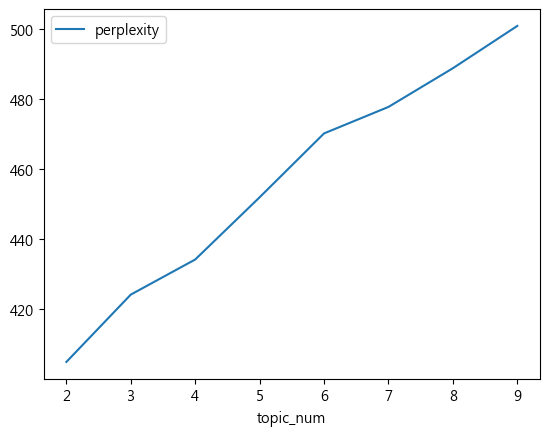

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

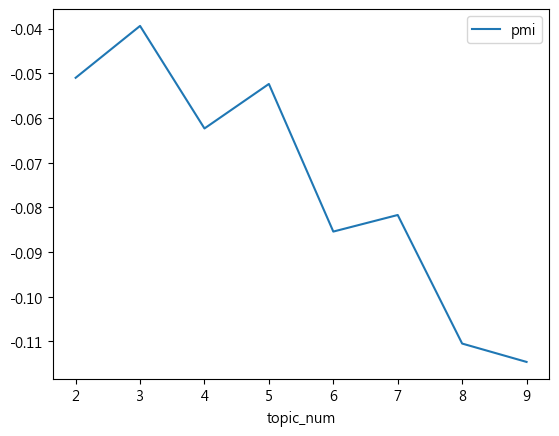

In [ ]:
result.plot.line(x='topic_num', y='pmi')

從上面兩張圖來看，Perplexity 隨著主題數增加而變差，PMI 也在主題數變多時明顯下降，代表主題越切越碎但品質沒變好。
所以我們可能不用切太多主題，建議選擇 2～4 顆主題之間是比較合理的範圍。



### 10.6 視覺化呈現



在本專案中，我們利用 LDAvis 對合作金庫 App 使用者評論進行主題模型視覺化。透過互動式圖表，可以：

- 直觀觀察不同主題（如登入問題、密碼重設、金融業務等）在評論中的分布情形
- 分析各主題間的相似性與差異性，協助辨識用戶主要關注的議題
- 進一步探索每個主題的代表性關鍵詞，了解用戶在不同主題下的具體反饋內容

這有助於產品團隊針對用戶痛點進行優化，並追蹤不同版本或時期下主題分布的變化。



In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 6969,
    passes = 10 # 訓練次數
    )

2025-06-10 01:27:36,731 : INFO : using symmetric alpha at 0.2
2025-06-10 01:27:36,732 : INFO : using symmetric eta at 0.2
2025-06-10 01:27:36,732 : INFO : using serial LDA version on this node
2025-06-10 01:27:36,733 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 3006 documents, updating model once every 2000 documents, evaluating perplexity every 3006 documents, iterating 50x with a convergence threshold of 0.001000
2025-06-10 01:27:36,733 : INFO : PROGRESS: pass 0, at document #2000/3006
2025-06-10 01:27:36,974 : INFO : merging changes from 2000 documents into a model of 3006 documents
2025-06-10 01:27:36,975 : INFO : topic #0 (0.200): 0.083*"無法" + 0.071*"更新" + 0.041*"登入" + 0.021*"轉帳" + 0.017*"顯示" + 0.014*"錯誤" + 0.011*"資料" + 0.011*"連線" + 0.010*"密碼" + 0.010*"好用"
2025-06-10 01:27:36,976 : INFO : topic #1 (0.200): 0.058*"無法" + 0.029*"登入" + 0.024*"更新" + 0.016*"下載" + 0.013*"系統" + 0.012*"問題" + 0.011*"網路" + 0.011*"已經" + 0.011*"客服" + 0.011*

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.225682  0.127574       1        1  23.703042
2     -0.059767 -0.018927       2        1  22.313789
0      0.215865 -0.009586       3        1  22.183009
4      0.124602  0.135170       4        1  17.831993
3     -0.055017 -0.234231       5        1  13.968167, topic_info=    Term        Freq       Total Category  logprob  loglift
10    無法  653.000000  653.000000  Default  30.0000  30.0000
2     更新  608.000000  608.000000  Default  29.0000  29.0000
181   通知  170.000000  170.000000  Default  28.0000  28.0000
16    密碼  191.000000  191.000000  Default  27.0000  27.0000
3     登入  545.000000  545.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
352   快速   18.425897   51.842082   Topic5  -4.9793   0.9339
44    系統   23.591066  149.966825   Topic5  -4.7322   0.1188
75    真的   22.043968  157.698481   Topic5  -4.8000   0.0007
193   一次   18.788739   64.522090   Topic5  -4.9598   0.7346
22    問題   20.419808  184.788000   Topic5  -4.8766  -0.2343

[327 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
332       1  0.180746     ....
332       4  0.783233     ....
114       3  0.902989    .....
142       1  0.970362      ATM
159       4  0.966263  Android
...     ...       ...      ...
130       1  0.975993       餘額
329       1  0.018451       驗證
329       2  0.110703       驗證
329       5  0.867177       驗證
660       4  0.882001       點開

[529 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 5, 4])

In [ ]:
best_model.print_topics()

2025-06-10 01:27:50,718 : INFO : topic #0 (0.200): 0.131*"無法" + 0.093*"更新" + 0.065*"登入" + 0.028*"連線" + 0.025*"系統" + 0.023*"伺服器" + 0.016*"顯示" + 0.016*"截圖" + 0.016*"下載" + 0.015*"進不去"
2025-06-10 01:27:50,719 : INFO : topic #1 (0.200): 0.035*"轉帳" + 0.031*"帳戶" + 0.025*"功能" + 0.021*"真的" + 0.021*"臨櫃" + 0.020*"申請" + 0.019*"數位" + 0.018*"難用" + 0.015*"網銀" + 0.013*"查詢"
2025-06-10 01:27:50,720 : INFO : topic #2 (0.200): 0.046*"登入" + 0.044*"密碼" + 0.034*"轉帳" + 0.028*"輸入" + 0.020*"設定" + 0.018*"指紋" + 0.018*"網銀" + 0.016*"重新" + 0.015*"問題" + 0.014*"錯誤"
2025-06-10 01:27:50,720 : INFO : topic #3 (0.200): 0.063*"通知" + 0.026*"信用卡" + 0.026*"設定" + 0.021*"顯示" + 0.020*"失敗" + 0.019*"登入" + 0.019*"入帳" + 0.017*"驗證" + 0.015*"每次" + 0.014*"頁面"
2025-06-10 01:27:50,721 : INFO : topic #4 (0.200): 0.046*"更新" + 0.030*"方便" + 0.026*"開啟" + 0.020*"程式" + 0.017*"畫面" + 0.015*"問題" + 0.014*"閃退" + 0.013*"轉圈圈" + 0.013*"完全" + 0.011*"不錯"


[(0,
  '0.131*"無法" + 0.093*"更新" + 0.065*"登入" + 0.028*"連線" + 0.025*"系統" + 0.023*"伺服器" + 0.016*"顯示" + 0.016*"截圖" + 0.016*"下載" + 0.015*"進不去"'),
 (1,
  '0.035*"轉帳" + 0.031*"帳戶" + 0.025*"功能" + 0.021*"真的" + 0.021*"臨櫃" + 0.020*"申請" + 0.019*"數位" + 0.018*"難用" + 0.015*"網銀" + 0.013*"查詢"'),
 (2,
  '0.046*"登入" + 0.044*"密碼" + 0.034*"轉帳" + 0.028*"輸入" + 0.020*"設定" + 0.018*"指紋" + 0.018*"網銀" + 0.016*"重新" + 0.015*"問題" + 0.014*"錯誤"'),
 (3,
  '0.063*"通知" + 0.026*"信用卡" + 0.026*"設定" + 0.021*"顯示" + 0.020*"失敗" + 0.019*"登入" + 0.019*"入帳" + 0.017*"驗證" + 0.015*"每次" + 0.014*"頁面"'),
 (4,
  '0.046*"更新" + 0.030*"方便" + 0.026*"開啟" + 0.020*"程式" + 0.017*"畫面" + 0.015*"問題" + 0.014*"閃退" + 0.013*"轉圈圈" + 0.013*"完全" + 0.011*"不錯"')]

### 主題說明

- **主題一：登入與更新失敗 / 系統連線異常**
    - 這個主題的關鍵詞集中於使用者「無法登入」、「更新後出錯」、「連不上伺服器」等嚴重系統性問題，是屬於高頻率的技術錯誤與使用中斷型抱怨。
- **主題二：帳戶操作與功能體驗**
    - 這個主題涉及轉帳、數位帳戶、功能使用與申請等操作，反映使用者對「功能可用性與便利性」的整體感受；雖有正負混合，但大多屬中性偏負面，像是「難用」、「臨櫃」等詞。
- **主題三：帳號驗證與登入過程問題**
    - 此主題聚焦於「登入失敗」、「密碼輸入」、「重新設定」、「指紋辨識」等驗證流程，屬於偏技術性的帳戶存取與驗證流程困擾，常見於登入體驗不佳的回饋。
- **主題四：通知與帳務提醒系統**
    - 以「通知」、「入帳」、「信用卡」、「驗證」為核心，這個主題代表使用者對於金融交易提醒、訊息設定、畫面呈現的關注；偏向資訊系統溝通與介面設計層面。
- **主題五：更新後使用體驗與程式穩定性**
    - 此主題結合「方便」、「開啟」、「程式閃退」與「轉圈圈」等詞，反映使用者對 App 更新後整體流暢度與穩定性的感受，屬於混合型情緒，可能有好壞差異。

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

## 10.7. GuidedLDA 主題模型

GuidedLDA（引導式 LDA）是一種半監督主題模型方法，允許我們透過人工指定的「種子詞」來引導主題的生成。這種方法結合了無監督學習的彈性與專家知識的導入，能讓模型更聚焦於我們關心的主題領域。

在本專案中，我們根據合作金庫 App 使用者評論的常見議題（如登入困難、系統錯誤、操作體驗、轉帳功能、客服回應等），設計了多組主題種子詞，並利用 GuidedLDA 進行主題建模。這有助於：

- 強化模型對特定主題的辨識能力
- 讓主題結果更貼近實際應用需求
- 輔助後續主題分布、趨勢分析與視覺化

以下將展示 GuidedLDA 的建模流程與主題詞彙結果。

In [ ]:
import guidedlda

In [ ]:
word2id = dictionary.token2id

In [ ]:
seed_topic_list = [
    # 登入困難與驗證問題
    ["登入", "密碼", "驗證", "OTP", "指紋", "登錄", "帳號", "解鎖", "憑證"],

    # 系統錯誤與閃退崩潰
    ["錯誤", "失敗", "閃退", "當機", "無法", "載入", "跳出", "伺服器", "系統"],

    # 使用體驗差與操作不便
    ["難用", "介面", "複雜", "輸入", "設計", "不行", "不好", "直覺"],

    # 轉帳與功能問題
    ["轉帳", "查詢", "交易", "功能", "不到", "失敗",  "操作"],

    # 客戶服務與問題回應
    ["客服", "處理", "等待", "回覆", "聯絡", "問題", "電話"]
]

In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=5278, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-05-18 18:07:36,256 : INFO : n_documents: 3006
2025-05-18 18:07:36,257 : INFO : vocab_size: 755
2025-05-18 18:07:36,257 : INFO : n_words: 21241
2025-05-18 18:07:36,258 : INFO : n_topics: 5
2025-05-18 18:07:36,259 : INFO : n_iter: 100
2025-05-18 18:07:36,261 : WARNING : all zero row in document-term matrix found
2025-05-18 18:07:36,339 : INFO : <0> log likelihood: -189910
2025-05-18 18:07:36,405 : INFO : <20> log likelihood: -133640
2025-05-18 18:07:36,471 : INFO : <40> log likelihood: -132462
2025-05-18 18:07:36,537 : INFO : <60> log likelihood: -131871
2025-05-18 18:07:36,604 : INFO : <80> log likelihood: -131249
2025-05-18 18:07:36,668 : INFO : <99> log likelihood: -131077


In [ ]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_
# 取得corpus全部的詞彙表
vocab = tuple(dictionary.token2id.keys())

for i, topic_dist in enumerate(topic_word):
    # 依照詞語機率從小到大排序，找出每個主題的前十個關鍵詞
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))


doc_topic = model.doc_topic_ # 文件-主題 分佈
term_freq = tuple(dictionary.cfs.values()) # 每個詞在整個語料中出現的總次數
doc_len = [sum(v for k, v in doc) for doc in corpus] # 每篇文章的長度

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 登入 更新 密碼 無法 一直 指紋 app 設定 錯誤 輸入
Topic 1: 無法 一直 更新 登入 使用 伺服器 連線 系統 顯示 失敗
Topic 2: 銀行 app 申請 難用 APP 臨櫃 真的 網銀 轉帳 帳戶
Topic 3: 轉帳 功能 通知 銀行 方便 查詢 無法 app 帳戶 帳號
Topic 4: 更新 登入 問題 無法 手機 使用 一直 app 客服 10


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.059271  0.074771       1        1  22.706936
3      0.160742  0.167816       2        1  21.931478
1     -0.234599  0.014563       3        1  21.638019
2      0.244447 -0.134225       4        1  18.451624
4     -0.111319 -0.122925       5        1  15.271943, topic_info=    Term        Freq       Total Category  logprob  loglift
11    無法  752.000000  752.000000  Default  30.0000  30.0000
3     登入  642.000000  642.000000  Default  29.0000  29.0000
52    一直  503.000000  503.000000  Default  28.0000  28.0000
17    密碼  190.000000  190.000000  Default  27.0000  27.0000
75    銀行  364.000000  364.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
75    銀行   36.991338  364.666622   Topic5  -4.4739  -0.4091
138   網銀   28.995372  170.864314   Topic5  -4.7174   0.1054
103   顯示   28.995372  210.566908   Topic5  -4.7174  -0.1035
137   合庫   24.997389  108.947425   Topic5  -4.8658   0.4071
44    畫面   22.998397  113.806385   Topic5  -4.9491   0.2801

[354 rows x 6 columns], token_table=      Topic      Freq Term
term                      
266       2  0.159519   10
266       3  0.203024   10
266       5  0.638074   10
471       5  0.994983   30
752       1  0.991817  30%
...     ...       ...  ...
140       2  0.375267   麻煩
140       3  0.075053   麻煩
140       4  0.125089   麻煩
140       5  0.237669   麻煩
348       2  0.997471   黃金

[560 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3, 5])

### 10.8 LDA主題分布應用：觀察每日主題文章佔比變化

在訓練完LDA主題模型後，我們可以將訓練好的模型應用於整個評論資料集，推論每篇評論屬於各主題的機率分布。接著，根據評論App版本，進一步觀察主題隨時間的變化趨勢。

這樣的分析有助於：

- 追蹤用戶關注議題的變化
- 發現特定時期或版本下，某些主題的討論熱度是否上升或下降
- 協助產品團隊針對熱門或負面主題進行優化

以下將展示如何將LDA模型推論結果轉換為主題分布，並進行主題趨勢的統計與視覺化。

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

In [ ]:
topics_doc[0]

[(0, 0.8380139),
 (1, 0.040187884),
 (2, 0.040540498),
 (3, 0.040295485),
 (4, 0.04096221)]

In [ ]:
df.iloc[0]

reviewId      179e2c16-8898-4086-96ff-b897f0284ac4
score                                            1
content                          更新後完全登入不進去，請立即改善。
artDate                        2017-12-29 18:17:05
appVersion                                    3.15
userName                                Google 使用者
words                         [更新, 完全, 登入, 立即, 改善]
Name: 0, dtype: object

#### 將 LDA 模型推論後的每篇文件的 主題分布（也就是 𝜃）轉換成一個 NumPy 矩陣（array）

In [ ]:
# 把 gensim 的稀疏表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray() # 倒置讓shape變為(num_docs, num_topics)
m_theta

array([[0.8380031 , 0.04018791, 0.04054061, 0.04029553, 0.04097288],
       [0.03373957, 0.03443472, 0.86293328, 0.03441683, 0.03447558],
       [0.27773473, 0.03344193, 0.03341633, 0.27668661, 0.37872037],
       ...,
       [0.28379413, 0.39540446, 0.0403299 , 0.23991296, 0.04055852],
       [0.17892376, 0.73381364, 0.02862877, 0.02859864, 0.03003518],
       [0.01826454, 0.54810524, 0.01868254, 0.01916627, 0.39578143]])

In [ ]:
# 將主題的機率分布轉換成主題標籤
df['topic_label'] = m_theta.argmax(axis=1) + 1

#### 統計一下各個主題的數量

In [ ]:
df['topic_label'].value_counts()

topic_label
1    1123
5     584
2     532
3     461
4     306
Name: count, dtype: int64

In [ ]:
df.head()

,reviewId,score,content,artDate,appVersion,userName,words,topic_label
0,179e2c16-8898-4086-96ff-b897f0284ac4,1,更新後完全登入不進去，請立即改善。,2017-12-29 18:17:05,3.15,Google 使用者,"[更新, 完全, 登入, 立即, 改善]",1
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,3,希望可以新增圖形手勢或是指紋登入,2017-12-22 16:00:34,3.15,Google 使用者,"[希望, 新增, 圖形, 手勢, 指紋, 登入]",3
2,ed390033-a91c-4146-bde7-d4533145e9ba,1,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,2017-12-21 12:25:16,3.15,Google 使用者,"[五顆星, 員工, 載入, 無法, 進入, 有沒有, 搞錯, 大哥]",5
3,7eb57a03-e2dc-4bba-a0bd-9a059d6c0254,5,平安，很好。,2017-12-20 16:00:13,3.15,Google 使用者,[平安],1
4,90a8f503-05a0-4459-9b53-a9d57439cc7b,3,為什麼沒有台幣定存,2017-12-20 08:43:32,3.15,Google 使用者,"[台幣, 定存]",2


#### 查看每天每個主題的文章相對比例（占比）

In [ ]:
df['major_version'] = df['appVersion'].str.split('.').str[:2].str.join('.')
df.groupby('major_version')['topic_label'].value_counts(normalize=True)

major_version  topic_label
3.11           1              0.500000
               2              0.250000
               4              0.250000
3.12           1              0.666667
               2              0.333333
3.13           1              0.521739
               5              0.182609
               3              0.130435
               2              0.095652
               4              0.069565
3.14           1              0.460526
               2              0.171053
               3              0.171053
               5              0.131579
               4              0.065789
3.15           1              0.521127
               5              0.183099
               2              0.140845
               3              0.112676
               4              0.042254
3.16           1              0.457589
               5              0.162946
               3              0.154018
               2              0.140625
               4              0.08482

In [ ]:
date_topic = df.groupby(df['appVersion'])['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5
appVersion,,,,,
3.11,0.500000,0.250000,NaN,0.250000,NaN
3.12,0.666667,0.333333,NaN,NaN,NaN
3.13,0.521739,0.095652,0.130435,0.069565,0.182609
3.14,0.460526,0.171053,0.171053,0.065789,0.131579
3.15,0.521127,0.140845,0.112676,0.042254,0.183099


#### 視覺化呈現主題文章趨勢變化

c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


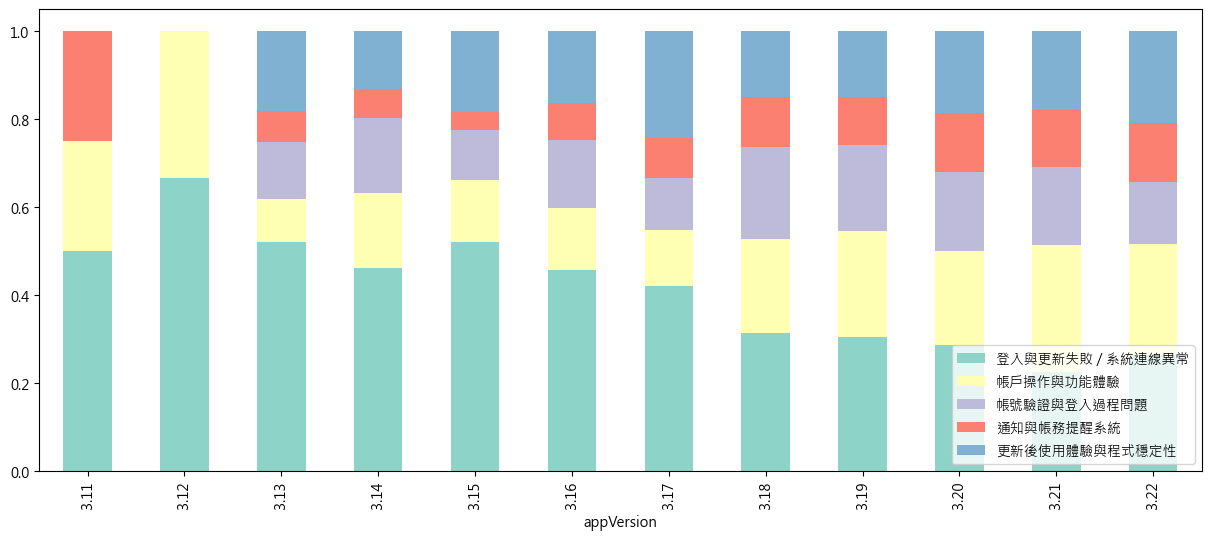

In [ ]:
"""
主題一 登入與更新失敗 / 系統連線異常
主題二 帳戶操作與功能體驗
主題三 帳號驗證與登入過程問題
主題四 通知與帳務提醒系統
主題五 更新後使用體驗與程式穩定性
"""

date_topic.columns = [
    "登入與更新失敗 / 系統連線異常",
    "帳戶操作與功能體驗",
    "帳號驗證與登入過程問題",
    "通知與帳務提醒系統",
    "更新後使用體驗與程式穩定性"
]


fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

這段畫出 堆疊長條圖，X 軸是 app 版本，Y 軸是各主題佔比。可以用來看：

哪個主題在某個版本爆量出現

哪些主題隨著版本更新漸漸消失或成長



## 11. 主題分布與特徵詞分析

本節針對合作金庫 App 使用者評論進行更深入的主題特徵分析，探討：

- 不同評分等級下的主題分布差異
- 各主題代表性詞彙與關聯性
- 主題詞彙的權重分布與視覺化
- 主題之間的相似度與差異

透過這些分析，我們可以：
- 識別用戶最關心的功能與問題
- 找出不同評分背後的主要原因
- 協助產品團隊優先改善重要議題

In [ ]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager


In [ ]:
# 讀入中文示範資料集
origin_data = pd.read_csv('merged_data.csv')

In [ ]:
origin_data.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,179e2c16-8898-4086-96ff-b897f0284ac4,Google 使用者,https://play-lh.googleusercontent.com/EGemoI2N...,更新後完全登入不進去，請立即改善。,1,0,3.15.1219,2017-12-29 18:17:05,有關本行行動網銀app交易係因帳務主機交易量大處理回應緩慢，致使行動網銀app交易遲緩，未能...,2018-01-11 11:02:41,3.15.1219
1,781b02f8-bc78-4240-bb9e-45b2d9ccd61f,Google 使用者,https://play-lh.googleusercontent.com/EGemoI2N...,希望可以新增圖形手勢或是指紋登入,3,0,3.15.1219,2017-12-22 16:00:34,您好，感謝您寶貴的建議，未來改版會納入考量。,2018-01-03 09:53:23,3.15.1219
2,ed390033-a91c-4146-bde7-d4533145e9ba,Google 使用者,https://play-lh.googleusercontent.com/EGemoI2N...,按五顆星的自己員工逆？ 載入都無法進入的app 有沒有搞錯啊 錢不是這樣花的阿大哥,1,7,3.15.1219,2017-12-21 12:25:16,您好，已於2017/12/20更新版本，請下載使用。,2018-01-03 09:54:09,3.15.1219


In [ ]:
# 去除一些不需要的欄位
metaData = origin_data[['content']]

# 只留下中文字
metaData['content'] = metaData['content'].str.replace(r'\n\n','。', regex=True)
metaData['content'] = metaData['content'].str.replace(r'\n','', regex=True)


metaData = metaData.explode('content').reset_index(drop=True)

metaData['content'] = metaData['content'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
metaData = metaData.dropna().reset_index(drop=True)
metaData.head()

,content
0,更新後完全登入不進去請立即改善
1,希望可以新增圖形手勢或是指紋登入
2,按五顆星的自己員工逆載入都無法進入的有沒有搞錯啊錢不是這樣花的阿大哥
3,平安很好
4,為什麼沒有台幣定存


In [ ]:

# 中文文章
docs_zh = metaData['content'].tolist()[:500]

# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增 stopwords
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("BAAI/bge-m3")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
hdbscan_model = HDBSCAN()

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopWords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2025-05-18 19:37:51,247 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-18 19:38:01,509 - BERTopic - Dimensionality - Completed ✓
2025-05-18 19:38:01,510 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-18 19:38:01,541 - BERTopic - Cluster - Completed ✓
2025-05-18 19:38:01,546 - BERTopic - Representation - Fine-tuning topics using representation models.
Building prefix dict from c:\Users\hank\Desktop\sb\dict\dict.txt.big ...
Loading model from cache C:\Users\hank\AppData\Local\Temp\jieba.u465ee282b7ba9db18471e8710c3c9621.cache
Loading model cost 0.974 seconds.
Prefix dict has been built successfully.
2025-05-18 19:38:02,591 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,110,-1_ _一直_登入_錯誤,"[ , 一直, 登入, 錯誤, 伺服器, 問題, 顯示, 處理, 異常, 失敗, 憑證, 資...","[系統異常請洽銀行客服人員但一直沒人處理阿, 怎麼一直顯示伺服器錯誤, 更新後就無法登入一直..."
1,0,73,0_登入_無法_ _一直,"[登入, 無法, , 一直, 登錄, 今天, 請, 辦法, 進入, 登, 幾天, 正常, ...","[無法登入, 無法登入, 無法登入]"
2,1,50,1_銀行_信用卡_網銀_登入,"[銀行, 信用卡, 網銀, 登入, 查詢, 成功, , 使用, 合庫, 登, 失敗, 申請...",[為何要查詢信用卡帳單卻要我登入個人網銀明明在你們網頁版只要登入信用卡會員就能查詢在卻不同調...
3,2,43,2_更新_使用_無法_卻,"[更新, 使用, 無法, 卻, 後, , 開啟, 一直, 安裝, 人, 程式, 系統, 問...","[不能更新, 無法更新, 無法更新]"
4,3,36,3_後_更新_無法_登入,"[後, 更新, 無法, 登入, 進不去, , 完全, 之後, 一直, 初始, 停, 初始化...","[更新後無法登入, 更新後無法登入, 更新後無法登入]"
5,4,34,4_轉帳_簡訊_帳號_匯款,"[轉帳, 簡訊, 帳號, 匯款, , 密碼, 無法, 認證碼, 機制, 收不到, 認證, ...","[轉帳收不到簡訊密碼, 更新後不能轉帳, 無法轉帳]"
6,5,32,5_方便_ _好_便利,"[方便, , 好, 便利, 服務, 平安, 加油, 讚, 好用, 行動, 謝謝, 实用, ...","[很方便, 方便, 很方便很好用]"
7,6,26,6_手機_支援_版本_三星,"[手機, 支援, 版本, 三星, 後, 解決, 重新安裝, 出現, , 下載, 更新, 事...",[更新後無法開啟出現不支援此手機我明明是原廠系統沒更改過麻煩改改好嗎更新後仍然出現不支援此手...
8,7,23,7_很爛_ _奇葩_爛,"[很爛, , 奇葩, 爛, 東西, 超爛, 爛到, 搞, 帳號密碼, 一點, 錯誤, 版,...","[爛死了今天早上七八點也登入不進去爛客服也不知跑哪去馬的這麼多人反應爛了也不懂得改進, 真的..."
9,8,22,8_打不開_開啟_ _開,"[打不開, 開啟, , 開, 死當, 程式, 連開, 完全, 改善, 客服, 卡住, 開是...","[打不開, 打不開啊, 打不開]"


In [ ]:
zh_topic_model.visualize_topics()

In [ ]:
# 估算每個文件對BERTopic每個主題的機率分布
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


In [ ]:
# 以第18個文件為例，列出這份文件對每個主題的機率分布
zh_topic_model.visualize_distribution(topic_distr[13])

In [ ]:
# 列出主題的代表詞和其對應的權重
zh_topic_model.get_topic(2)

[('更新', 0.17601102111153255),
 ('使用', 0.07746503103225992),
 ('無法', 0.06755337292227993),
 ('卻', 0.06375427002077816),
 ('後', 0.05668109945704502),
 (' ', 0.05219428650268092),
 ('開啟', 0.04481942032820539),
 ('一直', 0.03742030152843072),
 ('安裝', 0.03722836123450204),
 ('人', 0.03722836123450204),
 ('程式', 0.03324976552917237),
 ('系統', 0.031047937979315036),
 ('問題', 0.030165804815225506),
 ('強制', 0.028911360681799895),
 ('下載', 0.02832689959321674),
 ('櫃檯', 0.02553632970592024),
 ('這麼久', 0.02553632970592024),
 ('商店', 0.02349964872663861),
 ('真是', 0.02349964872663861),
 ('找', 0.02349964872663861),
 ('已經', 0.023313433838889466),
 ('說', 0.023313433838889466),
 ('好好', 0.022059285198428313),
 ('越', 0.022059285198428313),
 ('最新版', 0.022059285198428313),
 ('要求', 0.020945646977752166),
 ('修正', 0.020945646977752166),
 ('搞', 0.020038650717368094),
 ('解除', 0.020038650717368094),
 ('閃退', 0.01861418061725102)]

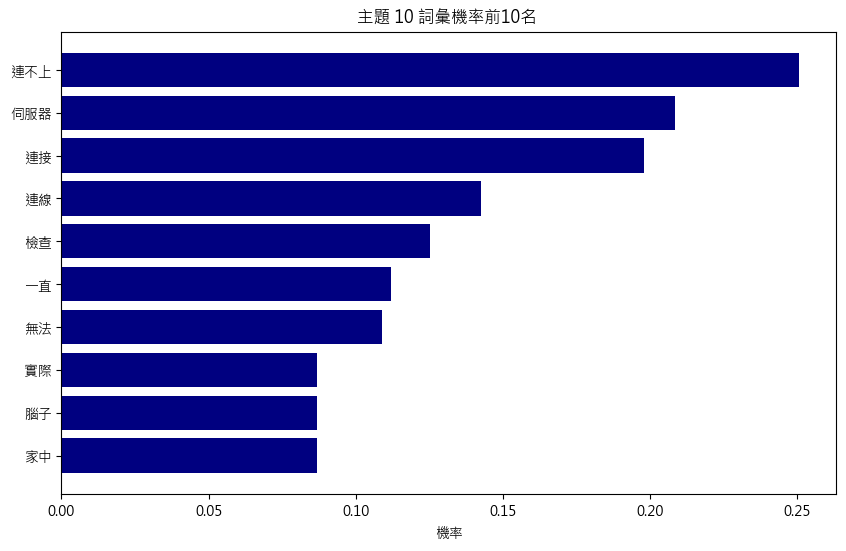

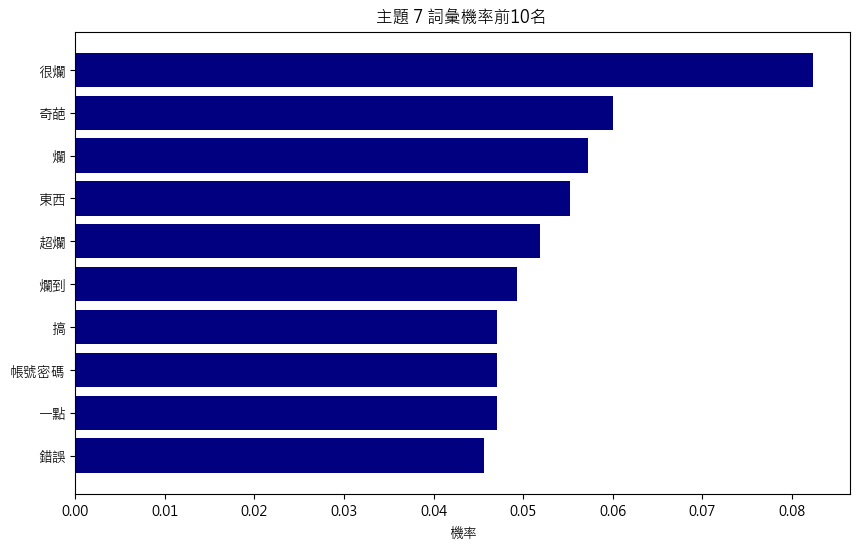

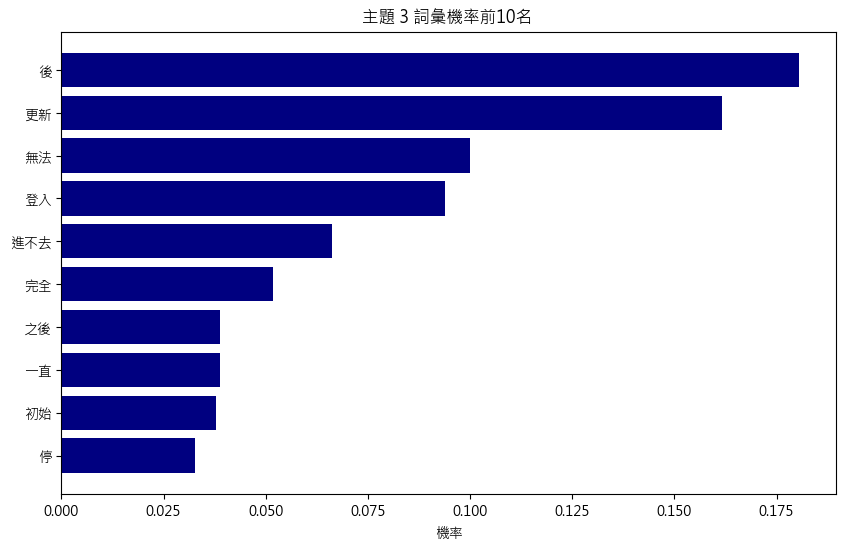

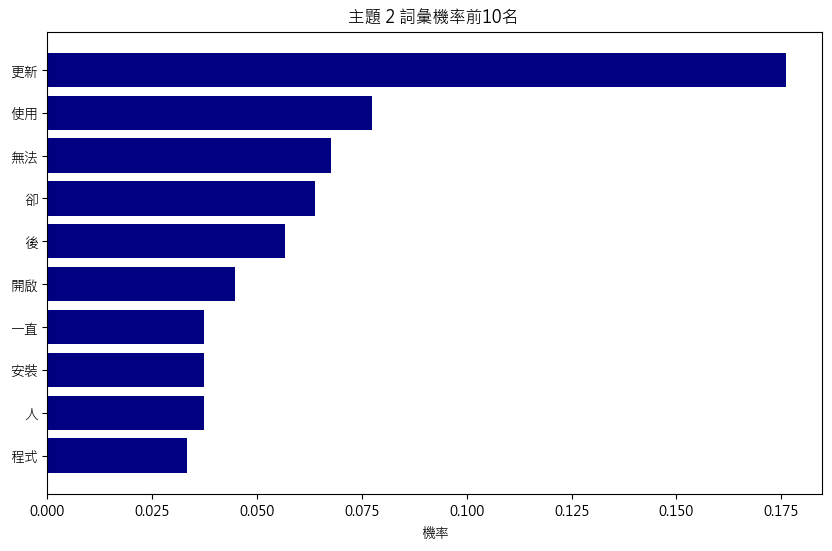

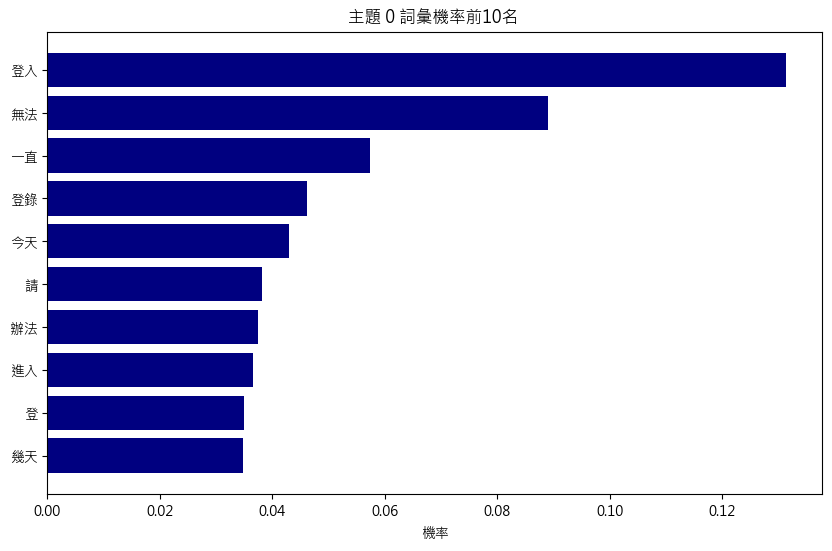

In [ ]:
top_distribution = [10,7,3,2,0]
for i in top_distribution:
    # 取得每個主題的關鍵詞
    topic_words = zh_topic_model.get_topic(i)

    # 轉換為DataFrame
    df = pd.DataFrame(topic_words, columns=['word', 'prob'])
    df = df[df['word'] != ' ']

    # 根據prob排序並選出前10名
    top_10 = df.sort_values('prob', ascending=False).head(10)

    # 畫出長條圖
    plt.figure(figsize=(10,6))
    plt.barh(top_10['word'], top_10['prob'], color='navy')
    plt.xlabel('機率')
    plt.title(f'主題 {i} 詞彙機率前10名 ')
    plt.gca().invert_yaxis()
    plt.show()

## 12. 社群網路分析

針對合作金庫 App 3.20-3.22 版本的使用者評論進行社群網路分析，探討：

- 使用者與不同版本之間的互動關係
- 評分傾向（正面/負面）的分布情形
- 評論連結的強度與特性

透過社群網路視覺化，我們可以：

- 識別用戶對各版本的評價傾向
- 觀察用戶反饋的版本集中度
- 發現潛在的問題模式與改善機會

這些洞察有助於產品團隊：

- 追蹤版本迭代的用戶反應
- 評估版本更新的影響
- 制定針對性的改善策略

In [ ]:
import pandas as pd
import numpy as np
import pyvis
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image

In [ ]:

select_versions = udn[udn['appVersion'].isin(['3.22', '3.21', '3.20'])]
select_versions


,reviewId,score,content,artDate,appVersion,userName,words
2306,e9f9244d-3a9c-4882-9687-d08d802619c1,1,很難操作晃半天進不去呢,2022-12-26 16:09:22,3.20,李妹蘭,"[很難, 操作, 半天, 進不去]"
2307,5a3f7d7c-ea2b-4fbd-8fe9-8b2b1c208d91,1,開啟入帳通知，結果金錢入帳都不會通知（對方還要備註薪資），難道被盜用人頭張戶，銀行負責嗎？都...,2022-12-16 21:37:41,3.20,林奕睿,"[開啟, 入帳, 通知, 金錢, 入帳, 通知, 對方, 還要, 備註, 薪資, 被盜, 用..."
2308,73f07fd6-1417-43ce-9a74-40093563c864,1,為啥我圖形登入，每次都要登入兩次？第一次完全沒反應，都要我先按取消再登入一次，太不方便了吧！,2022-12-16 00:52:07,3.20,阿樂,"[圖形, 登入, 每次, 登入, 兩次, 第一次, 完全, 反應, 取消, 登入, 一次, 方便]"
2309,e66dfdd0-77ec-478c-a904-c6d28300e9f9,1,程式一直繞圈圈，跑不動。顯示無法與伺服器連線 一直停在更新中5%,2022-12-07 07:38:34,3.20,晴天魚,"[程式, 一直, 繞圈圈, 跑不動, 顯示, 無法, 伺服器, 連線, 一直, 更新, 5%]"
2310,c3541a19-0abd-443b-b2f2-707c8e7b4365,1,爛+爛+爛+爛+爛,2022-12-06 22:54:07,3.20,奕德,[]
...,...,...,...,...,...,...,...
3001,256c78ca-38a0-4954-a18b-2824d8c946de,2,"原可轉帳，更新app後，OTP要跳出前都會出現訊息”太久未操做"", 多次試用都一樣",2024-01-03 19:30:13,3.21,Chris Lee,"[原可, 轉帳, 更新, app, OTP, 跳出, 出現, 訊息, 太久, 未操, 試用]"
3002,ef7f2908-14de-4ef1-9e81-c41dc7c99f4e,3,幾乎每次登入都要來一次同步資料真的非常浪費時間。,2024-01-03 14:31:06,3.21,Peggy Lee,"[每次, 登入, 要來, 一次, 同步, 資料, 真的, 浪費時間]"
3003,b29d2236-757a-4945-8881-67066dfa3bff,1,一天到晚在更新，所有銀行的app就屬你們最爛…,2024-01-03 08:13:00,3.21,5 A (A5和牛),"[一天到晚, 更新, 所有, 銀行, app, 就屬, 最爛]"
3004,79733990-ecc2-44ff-8c08-01cde53e6fae,3,有夠難用，到底有沒有在認真經營，學學別家銀行啦,2024-01-02 18:45:40,3.21,CY Y,"[有夠, 難用, 有沒有, 認真, 經營, 學學, 別家, 銀行]"


In [ ]:
#parse comment
import random



re_df = select_versions[['userName','appVersion','score']].rename(columns = {'userName':'src','appVersion':'dis','score':'weight'})
re_df = re_df[~re_df['src'].isna()]
re_df = re_df[~re_df['dis'].isna()]
re_df = re_df[~re_df['weight'].isna()]




def convertStatus(s):
  if s >3:
    return 2
  else :
    return -1
re_df['weight'] = re_df['weight'].map(convertStatus)
re_df = re_df.groupby(['src','dis']).sum().reset_index()

# 設定分數低的為紅色
def getColor(w):
  if w>0:
    return 'green'
  else:
    return 'red'
re_df['color'] = re_df.weight.map(getColor)


In [ ]:
import pyvis
from PIL import Image

netWork = pyvis.network.Network(notebook=True, cdn_resources='in_line',directed=True)


person = list(set(+re_df.src.unique().tolist()))
# 移除 url 中的 nan 值，建立 url_clean

netWork.add_nodes(
    nodes = person,
    value = [1 for i in range(len(person))],
    color = ['#66CDAA' for i in range(len(person))],
    title = person
)

for i in re_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color=i[3])

# 設定layout
netWork.repulsion()

# 產生 HTML 字串
html_content = netWork.generate_html()

# 手動以 utf-8 儲存檔案，避免 cp950 編碼錯誤
with open('network.html', 'w', encoding='utf-8') as f:
    f.write(html_content)


可以看到在社群網路圖片中 在三個版本 3.22 3.21 3.20 中的使用者與版本之間的關聯性
大多數為紅色負面連結
且大多數使用者只會評論一個版本



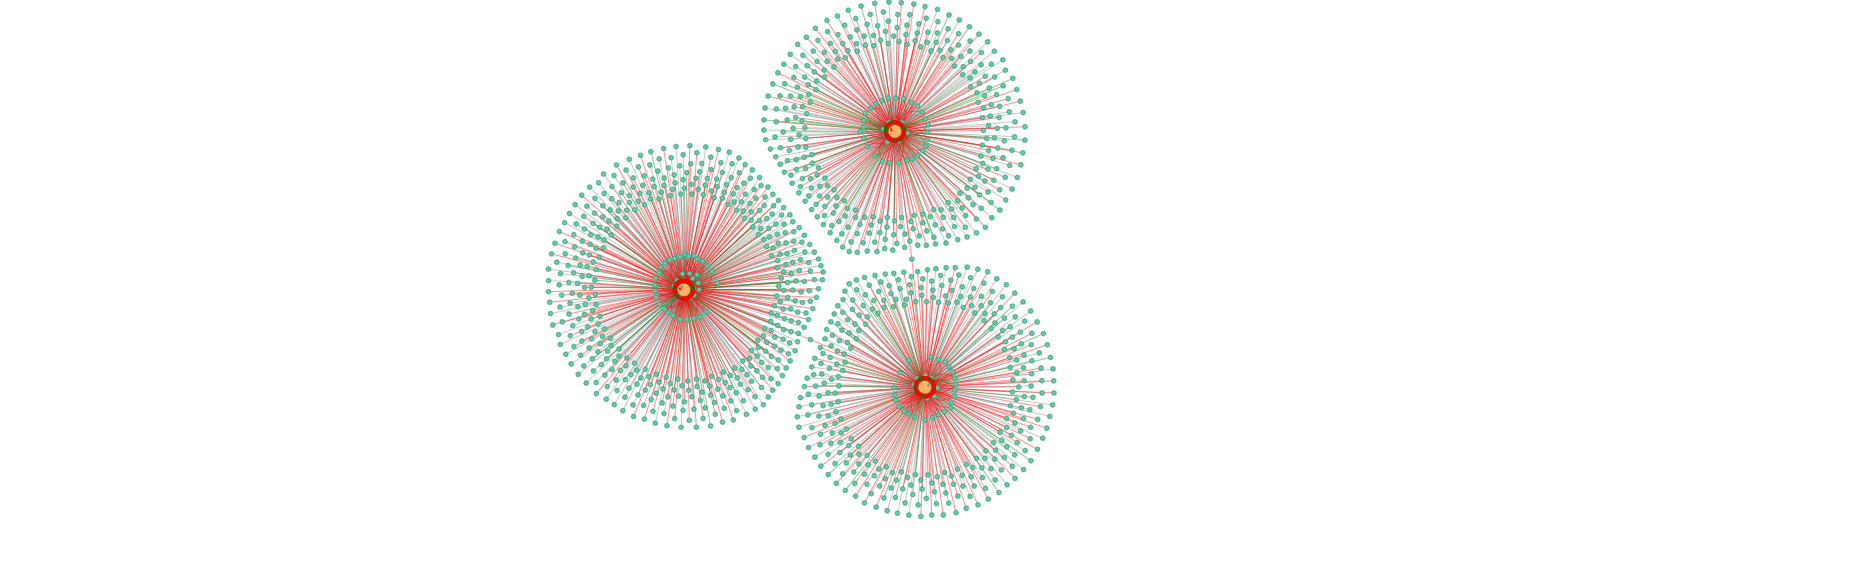

In [ ]:
Image.open('network.png')